#An Analysis of the Game of Chess
###Queens and Openings

 Contributors: Samantha Taskale, Ming Nelson, Nathan Blanken, Ben Drucker

Our Final Tutorial


---






#Motivation

The four researchers have known each other for a few years now. During that time Ming and Ben have always clashed over who is the better chess player. Both Ming and Ben have similar skill levels so there is a constant back and forth arguments between who has the better strategies and they both spend a lot of time figuring out how to improve their game to beat the other. When this project came along it was perfect fit to be able to analyze chess games so both Ming and Ben can work on their game, and you the reader can implement our findings into your game as well. The following report delves into various aspects of the game of Chess and goes through all of the steps of the data science lifecycle.

If you are not familiar with the game of chess, here is a resource with steps on how to setup a game and basic rules: https://www.chess.com/learn-how-to-play-chess

In [45]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as statapi
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as linreg
import sklearn
import statsmodels.api
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# the next two lines are specific to Google Colab and are not necessary
# if you are running this code in a local IDE (ONLY RUN IT ONCE)
# from google.colab import drive
# drive.mount('/content/drive')




---


# Data Collection 
Here we are pulling all of our data from https://www.kaggle.com/datasets/datasnaek/chess?resource=download. This is a set of just over 20,000 games collected from a selection of users on the site Lichess.org. This set contains:

    Game ID;
    Rated (T/F);
    Start Time;
    End Time;
    Number of Turns;
    Game Status;
    Winner;
    Time Increment;
    White Player ID;
    White Player Rating;
    Black Player ID;
    Black Player Rating;
    All Moves in Standard Chess Notation;
    Opening Eco (Standardised Code for any given opening, list here);
    Opening Name;
    Opening Ply (Number of moves in the opening phase)

For each of the separate games from Lichess. The owner of the dataset collected the data using the Lichess API, which enables collection of any given users game history. 

In [46]:
# All of the data from https://www.kaggle.com/datasets/datasnaek/chess?resource=download
entire_dataset = pd.read_csv("games.csv")
# Pulled the headers from the CSV file
print(entire_dataset.columns)


Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')


In the code block below we pull out only the games that were "rated". Rated games are games that have an impact on a player's skill rating. The greater the rating level a player has, the greater their skill should be. When a rated game is won a player's rating increases and when a rated game is lost a player's rating decreases. We decided to pull out only rated games in order to better analyze the different openings which we discuss below. It is believed that during rated games players will try harder and play more seriously because their rating will be impacted with a loss.

In [47]:
# Only keep games that were rated, not "casual"
rated_dataset = entire_dataset[entire_dataset["rated"] == True]



---


#Data Processing

The following block of code loops through the rated dataset and removes games that we are considering to be "bad games". We consider the following situations "bad games" thus we remove those games from our cleaned dataset:
1. One or more queens are not moved during the length of the game.
2. A pawn is promoted to a queen before both aueens are moved.

Here is some information about what is means to promote a pawn: https://www.chess.com/terms/pawn-promotion.

We plan to examine whether or not moving the queen early on in the game decreases the chance of winning the game. We want to examine a particular kind of game and in situations where the queen doesn't get moved and then a pawn is promoted to a queen is an abnormal, this skews the data and isn't within the focus of this examination. 

To determine if a queen has moved we look at the string of chess moves, turn it into an array, and look at the first character of each move to see if it is a "Q". If we find a "Q" we know it is a move by the queen. To find a pawn promotion we look for "=Q" which is the chess notation for a promotion to a queen. A promotion to a queen can only be done by a pawn so seeing that notation makes it easy to find the promotion. We can use the fact that white pieces always move first to determine whether it the black or white queen that moved or if it was a black or white pawn that was promoted to a queen.

In [48]:
#variables to keep track of whether either queen moved as well as if there was a pawn promotion before queen moved
black_queen_moved = False
white_queen_moved = False
pawn_promotion_before_queen_move = False
pawn_promotion_games = [] #array to track games where a pawn promotion happened before both queens moved for individual analysis purposes
cleaned_dataset = rated_dataset.copy() #setup the "clean" dataset
for i, row in rated_dataset.iterrows(): #for each row in the rated dataset
    #reset booleans to false
    black_queen_moved = False
    white_queen_moved = False
    pawn_promotion_before_queen_move = False
    moves = row[12].split() #split the moves array into individual elements to separate each move
    for j, move in enumerate(moves): #loop through all of the moves
        if j % 2 == 0: #even index is white
            if move[0] == 'Q': #check to see if queen is moved
                white_queen_moved = True 
            if white_queen_moved == False and black_queen_moved == False and '=Q' in move: #makes sure neither pawn has moved and there is a promotion to queen
                pawn_promotion_before_queen_move = True
                pawn_promotion_games.append(row[12])
        else: #odd index is black
            if move[0] == 'Q':
                black_queen_moved = True 
    if(black_queen_moved == False or white_queen_moved == False or pawn_promotion_before_queen_move == True): #If any of the above criteria are met then remove that game from the dataset we are going to use
        cleaned_dataset = cleaned_dataset.drop(i)

  #display(rated_dataset.head())


The first thing we will look into is the effect opening has on white and black's chances of winning. Openings are a way of describing the first phase of a chess game, classified by the order of the moves a player played. Here is a website where you can find more information about openings: https://chessfox.com/chess-openings-list/.

We want to sum the number of wins and ties for each of the colors (white and black). We will compile these numbers into a dictionary where all of the openings will correspond with [wins for black | wins for white | ties]. This begins to give us perspective on how the color and opening can impact a win. This can also show us if some openings are more favorable to one color or the other. 




In [49]:
# This code block sums up the number of wins for each white, black, and tie and 
# compiles a dictionary for all of the openings
#         num wins for black | num wins for white | num ties
openings = {}
for i, row in cleaned_dataset.iterrows():
    opening_name = row[14]  # get the opening name
    opening_eco = row[13]  # get the opening eco
    winner = row[6]  # get the winner of the game

    # initialize new dictionary entry for each opening name
    # (opening_eco, [white, black, tie, (white+black+tie=freq)])
    openings.setdefault(opening_name, (opening_eco, [0, 0, 0, 0]))  
    
    # increment the outcome of the current game
    if winner == 'white':
        openings[opening_name][1][0] += 1
    elif winner == 'black':
        openings[opening_name][1][1] += 1
    elif winner == 'draw':
        openings[opening_name][1][2] += 1
    # always increment the frequency
    openings[opening_name][1][3] += 1


The function "top_n" will return the top n most used openings. This helps us identify openings that are played very frequently so that we can see a higher sample size of games played with a specific opening. Sorted by top n frquency so to get the top 50 used openings we can use this function to ensure we are looking at well tested openings. 

In [50]:
def top_n(num, d):
    return sorted(d.items(), key=lambda x:x[1][1][3], reverse=True)[0:num]


This code snippet performs an analysis on the openings of the chess games. It identifies the top 50 most frequently used openings, sorts them by frequency, and creates a DataFrame to store the analyzed data. The DataFrame includes information such as the opening name, ECO code, number of wins for white and black players, number of draws, and the frequency of occurrence. By focusing on the top 50 most used openings, the code helps identify well-tested openings with a higher likelihood of success or failure.



In [51]:
# x values (bins) for all histograms
# display(openings)
# sorted_openings = sorted(openings.keys())
# return tuple of top 50 opening names and the associated data from the 
# openings dictionary
top_n_openings = top_n(50, openings)
# create new DataFrame to house data
top_n_openings_df = pd.DataFrame(columns=['Opening_Name', 'Opening_ECO', 'White_Wins', 'Black_Wins', 'Draws', 'Frequency'])
for i, opening in enumerate(top_n_openings):
    # extract data to populate DataFrame
    eco, data = openings[opening[0]]
    white, black, tie, freq = data
    top_n_openings_df.loc[i] = [opening[0], eco, white, black, tie, freq]
display(top_n_openings_df.head())

# x_values = [ele[0] for ele in top_n_openings]
# display(top_n_openings)

,Opening_Name,Opening_ECO,White_Wins,Black_Wins,Draws,Frequency
0,Sicilian Defense,B27,103,123,6,232
1,Van't Kruijs Opening,A00,63,144,11,218
2,Sicilian Defense: Bowdler Attack,B20,75,115,9,199
3,French Defense: Knight Variation,C00,92,80,13,185
4,Scandinavian Defense: Mieses-Kotroc Variation,B01,112,59,5,176


#Exploratory Analysis & Data Visualization

**Most Common (and Successful) Openings**

The following code is an analysis of win percentages for the top 50 most used openings and which piece color wins them the most. We decided to look at the 50 most played openings instead of the highest win rates for each respective color because there are many variations of openings that were only used one time and won. Those 100% win openings significantly skewed the results and we felt that it was not significant to the results we wanted to display. We instead only used the most frequently played and sorted it by how frequent the openings were used. 



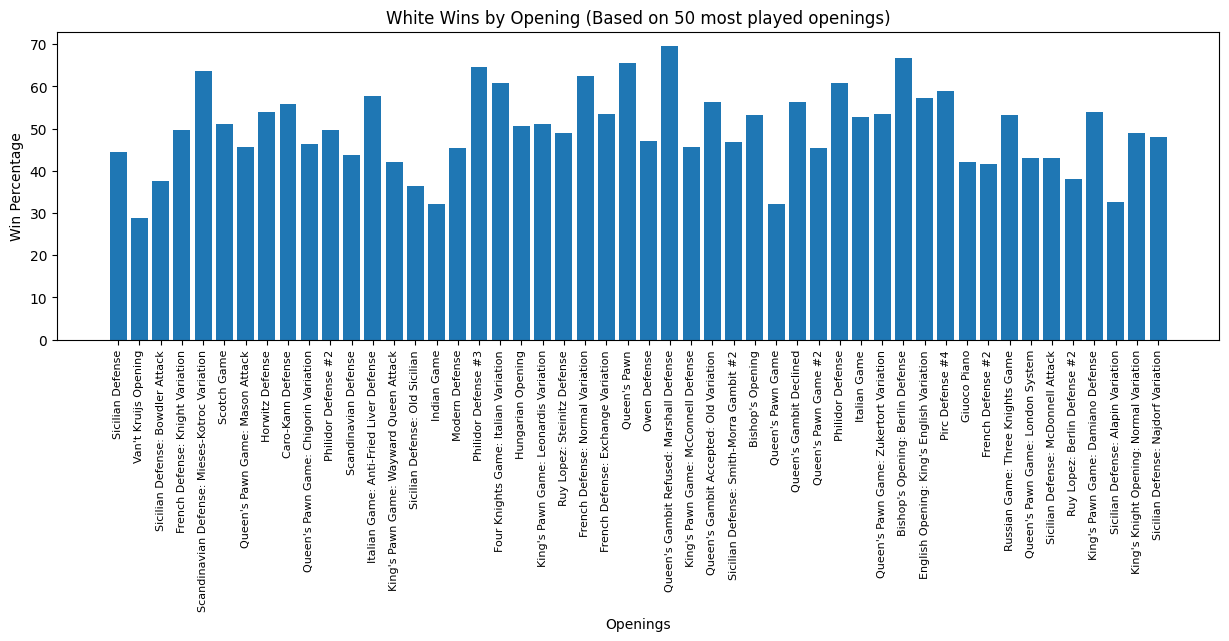

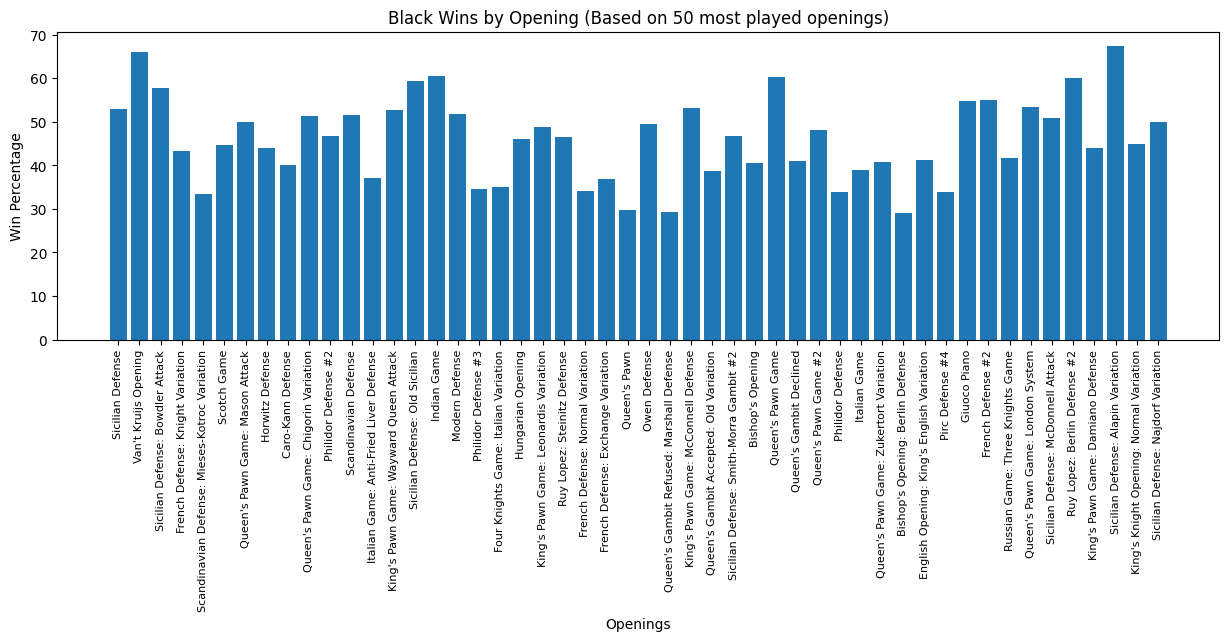

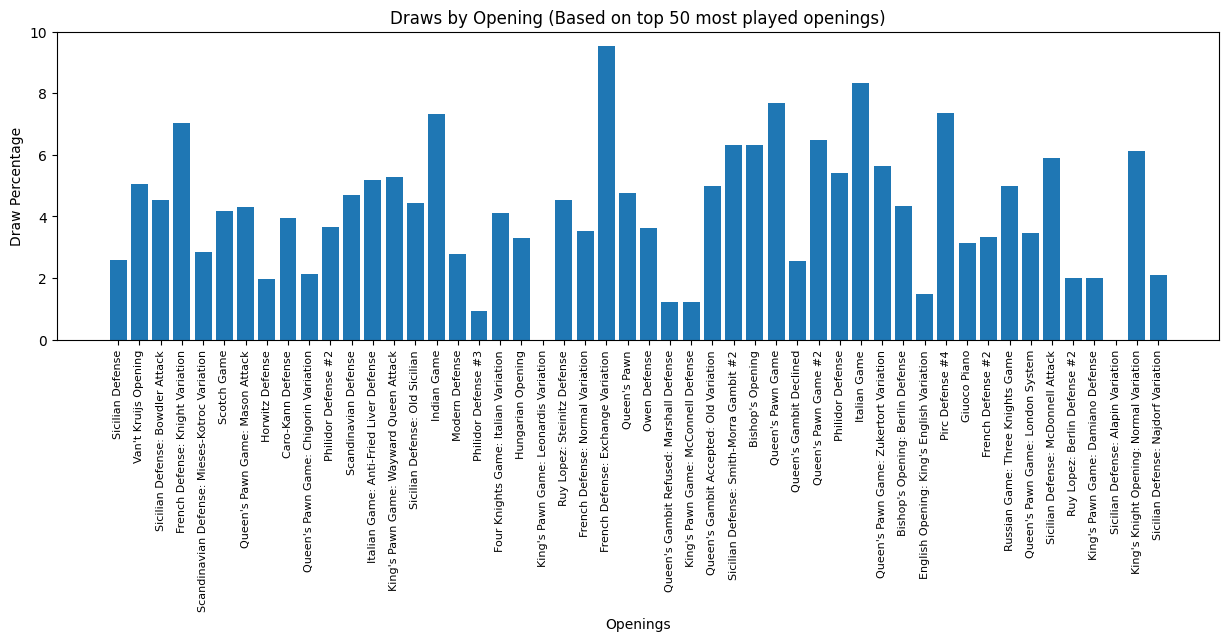

In [52]:
# The following code suppresses unnecessary warnings generated by matplotlib
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Make histogram for white win percentage
fig_w, ax_w = plt.subplots(figsize=(15, 4))

# Create a bar chart
white_win_percentage = 100*(top_n_openings_df['White_Wins'].astype(float)/top_n_openings_df['Frequency'].astype(float))
ax_w.bar(top_n_openings_df['Opening_Name'], white_win_percentage)

# Properly format ticks on the x-axis
ax_w.set_xticklabels(top_n_openings_df['Opening_Name'], rotation=90)
plt.xticks(fontsize=8)

# Set labels and title
ax_w.set_xlabel('Openings')
ax_w.set_ylabel('Win Percentage')
ax_w.set_title('White Wins by Opening (Based on 50 most played openings)')
plt.show()

########################################################################################################################
# make histogram for black win percentage
fig_b, ax_b = plt.subplots(figsize=(15, 4))

# Create a bar chart
black_win_percentage = 100*(top_n_openings_df['Black_Wins'].astype(float)/top_n_openings_df['Frequency'].astype(float))
ax_b.bar(top_n_openings_df['Opening_Name'], black_win_percentage)
# Properly format ticks on the x-axis
ax_b.set_xticklabels(top_n_openings_df['Opening_Name'], rotation=90)
plt.xticks(fontsize=8)
# Set labels and title
ax_b.set_xlabel('Openings')
ax_b.set_ylabel('Win Percentage')
ax_b.set_title('Black Wins by Opening (Based on 50 most played openings)')
plt.show()

########################################################################################################################
# make histogram for draw percentage
fig_d, ax_d = plt.subplots(figsize=(15, 4))

# Create a bar chart
draw_percentage = 100*(top_n_openings_df['Draws'].astype(float)/top_n_openings_df['Frequency'].astype(float))
ax_d.bar(top_n_openings_df['Opening_Name'], draw_percentage)
# Properly format ticks on the x-axis
ax_d.set_xticklabels(top_n_openings_df['Opening_Name'], rotation=90)
plt.xticks(fontsize=8)
# Set labels and title
ax_d.set_xlabel('Openings')
ax_d.set_ylabel('Draw Percentage')
ax_d.set_title('Draws by Opening (Based on top 50 most played openings)')
plt.show()

**Results:** When playing as white, the highest percentage of wins for the top 50 most commonly played openings came from the Queen's Gambit Refused with a win rate of about 70%. When playing as black, the highest percentage of wins for the top 50 most commonly played openings came from the Sicilian Defense: Alapin Variation with  win rates of about 67%. Of the 50 most played openings the French Defense: Exchange Variation was the opening that led to the highest percentage of draws at about 10%.

*It should be noted that some of the top 50 most commonly used openings had zero draws so they are still listed but have no bar.*



---

#Separating games by ECO

Every chess opening variation is part of a larger family of openings. Each family of openings is classified using an Opening ECO code. Opening ECO, which stands for Encyclopaedia of Chess Openings, represents a specific code for specific openings. Each one of these codes represents a way of classifying groups of openings. For example, openings with the code A00 are all variations of the Polish (Sokolsky) Opening. For more on opening ECO codes, you can visit this link: https://www.365chess.com/eco.php. 

In [53]:
# Create new dictionary to organize openings by ECO rather than name
eco_win_pct = {}
for i, row in cleaned_dataset.iterrows():
    opening_eco = row[13]  # get opening eco
    winner = row[6]  # get outcome of current game

    # initialize new dictionary entry for each opening name
    # white, black, tie, freq (white+black+tie=freq)
    eco_win_pct.setdefault(opening_eco, [0, 0, 0, 0])
    
    # increment the value associated with the outcome of the game
    if winner == 'white':
        eco_win_pct[opening_eco][0] += 1
    elif winner == 'black':
        eco_win_pct[opening_eco][1] += 1
    elif winner == 'draw':
        eco_win_pct[opening_eco][2] += 1
    # always increment frequency
    eco_win_pct[opening_eco][3] += 1

This code block is a simple function that grabs the top *n* number of openings based on how many times they are used.

In [54]:
def sort_top_n_eco(num, d):
    return sorted(d.items(), key=lambda x:x[1][3], reverse=True)[0:num]

There are too many variations of each ECO family so we decided to only grab the top 50 most common Opening ECOs. We then figure out how many wins each color has using that Opening ECO as well as how many draws there were.

In [55]:
# Make df for eco win_pct
top_n_eco = sort_top_n_eco(50, eco_win_pct)

# Initialize new DataFrame to house data
eco_df = pd.DataFrame(columns=['Opening_ECO', 'White_Wins', 'Black_Wins', 'Draws', 'Frequency'])

for i, eco in enumerate(top_n_eco):
  # extract relevant data to put into DataFrame
  e, data = eco
  white, black, tie, freq = data
  eco_df.loc[i] = [eco[0], white, black, tie, freq]

display(eco_df.head())

,Opening_ECO,White_Wins,Black_Wins,Draws,Frequency
0,C00,282,266,28,576
1,A00,224,317,21,562
2,D00,212,238,27,477
3,B01,239,208,17,464
4,C41,243,168,13,424


After splitting up the data to find the 50 most commonly used Opening ECOs, we graph them to see win percentage for both white, black, and what percent of the time there were draws using these families of openings.

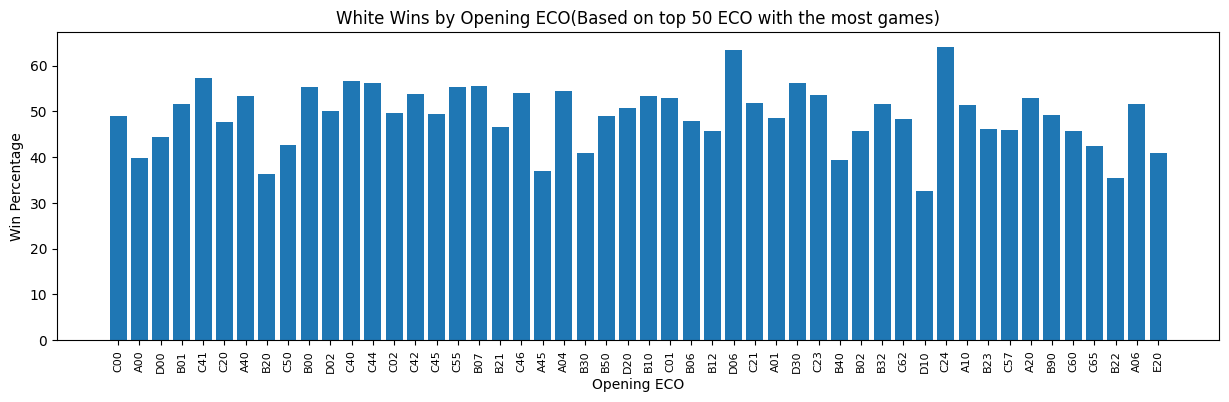

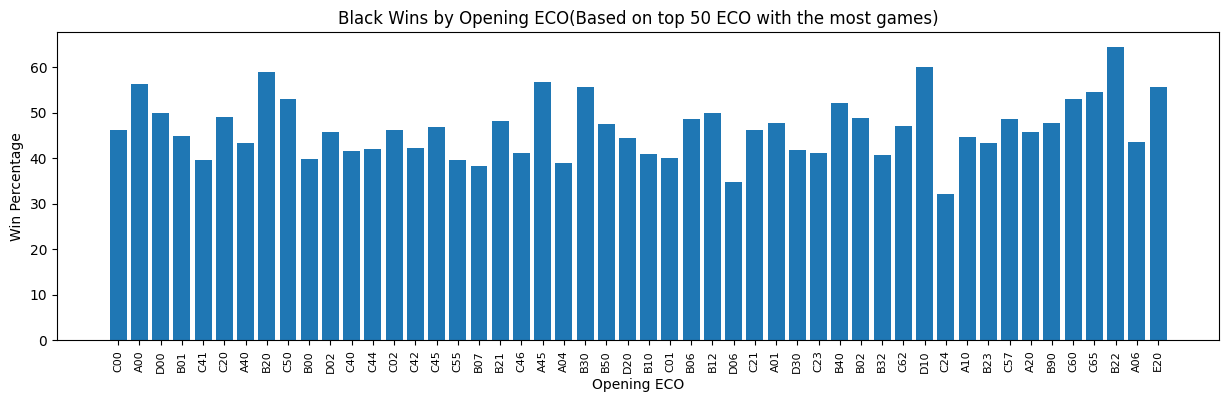

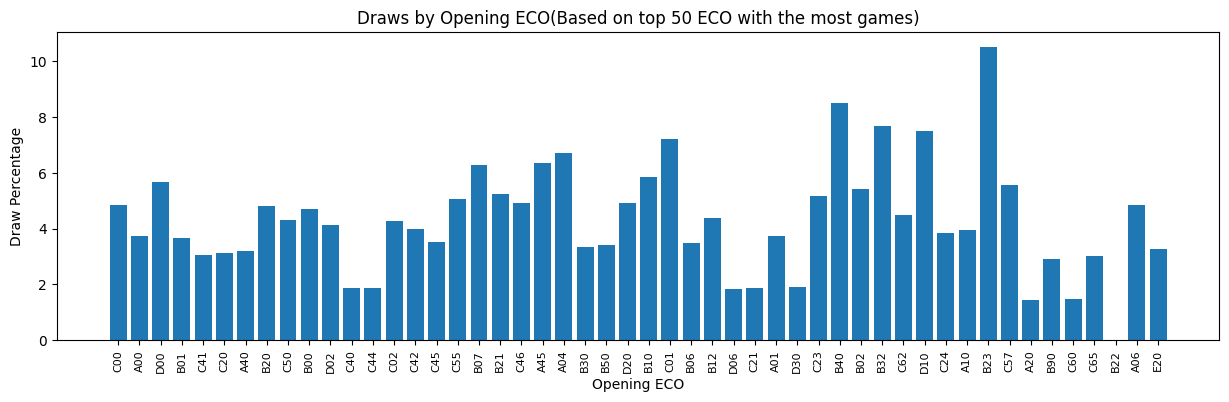

In [56]:
# make histogram for white win percentage for eco
fig_w, ax_w = plt.subplots(figsize=(15, 4))

# Create a bar chart
white_win_percentage = 100*(eco_df['White_Wins'].astype(float)/eco_df['Frequency'].astype(float))
ax_w.bar(eco_df['Opening_ECO'], white_win_percentage)
# Properly format ticks on the x-axis
ax_w.set_xticklabels(eco_df['Opening_ECO'], rotation=90)
plt.xticks(fontsize=8)
# Set labels and title
ax_w.set_xlabel('Opening ECO')
ax_w.set_ylabel('Win Percentage')
ax_w.set_title('White Wins by Opening ECO(Based on top 50 ECO with the most games)')
plt.show()


# make histogram for black win percentage for eco
fig_w, ax_w = plt.subplots(figsize=(15, 4))

# Create a bar chart
black_win_percentage = 100*(eco_df['Black_Wins'].astype(float)/eco_df['Frequency'].astype(float))
ax_w.bar(eco_df['Opening_ECO'], black_win_percentage)
# Properly format ticks on the x-axis
ax_w.set_xticklabels(eco_df['Opening_ECO'], rotation=90)
plt.xticks(fontsize=8)  #, width=10)
# Set labels and title
ax_w.set_xlabel('Opening ECO')
ax_w.set_ylabel('Win Percentage')
ax_w.set_title('Black Wins by Opening ECO(Based on top 50 ECO with the most games)')
plt.show()

# make histogram for white win percentage for eco
fig_d, ax_d = plt.subplots(figsize=(15, 4))

# Create a bar chart
draw_percentage = 100*(eco_df['Draws'].astype(float)/eco_df['Frequency'].astype(float))
ax_d.bar(eco_df['Opening_ECO'], draw_percentage)
# Properly format ticks on the x-axis
ax_d.set_xticklabels(eco_df['Opening_ECO'], rotation=90)
plt.xticks(fontsize=8)  #, width=10)
# Set labels and title
ax_d.set_xlabel('Opening ECO')
ax_d.set_ylabel('Draw Percentage')
ax_d.set_title('Draws by Opening ECO(Based on top 50 ECO with the most games)')
plt.show()

**Results:** For white the best opening ECOs are D06 (Queen's Gambit) and C24 (Bishop's Opening Berlin Defense). For black the best opening ECOs are D10 (Queen's Gambit Declined Slav Defense) and B22 (Sicilian Defense, Nimzowitsch Variation). For games where there was a draw, the most common openings where there were draws were B23 (Sicilian Defense, closed) and B40 (Sicilian Defense).

**Gathering Win Percentage Based on Number of Moves Before Moving The Queen**

There is a common strategy in chess that says you should not move your queen out early in the game. The reasoning for this is because you may be more likely to lose your queen if you move it out too early. We want to see if this is true. 

The following code loops through the cleaned dataset and counts how many games each color won at a certain number of moves before moving the queen. This is important to our model because we believe there is a trend between the number of moves a player makes before moving the queen and the percent of the time they win. With this code we build the foundation of collecting parameters for our machine learning model.

In [57]:
white_qwp = {}
black_qwp = {}
# Iterate through cleaned dataset to find 
for i, row in cleaned_dataset.iterrows():
    # split the string of moves into an array where the even indexed moves
    # are the white player's moves and the odd indexed moves are the black
    # player's moves
    moves = row[12].split()
    winner = row[6]  # get winner of the game
    black_count = 0  # track the number of moves until black moves the queen
    white_count = 0  # track the number of moves until white moves the queen
    w_queen_found = False  # track if white's queen has moved
    b_queen_found = False  # track if black's queen has moved
    for j, move in enumerate(moves):
        if j % 2 == 0: # even is white's move
            if move[0] == 'Q':
                w_queen_found = True                
            if not w_queen_found and move[0] != 'Q':
                white_count += 1
        else: # odd is black's move
            if move[0] == 'Q':
                b_queen_found = True
            if not b_queen_found and move[0] != 'Q':
                black_count += 1    
    white_qwp.setdefault(white_count, [0, 0])  # white wins, total games
    # always increment number of games played
    white_qwp[white_count][1] += 1
    # if white won, increment number of wins for white
    if winner == 'white':
        white_qwp[white_count][0] += 1
    black_qwp.setdefault(black_count, [0, 0])
    # always increment number of games played
    black_qwp[black_count][1] += 1
    # if black won, increment number of wins for black
    if winner == 'black':
        black_qwp[black_count][0] += 1



##Number of moves until queen was moved vs. win percentage for the player using the white pieces

Here we are creating a scatter plot with a regression line in order to visualize the relationship between the number of moves until the queen is moved and the win percentage of a player who is using white pieces. This graph provides us insight into whether there is a correlation between these factors. 

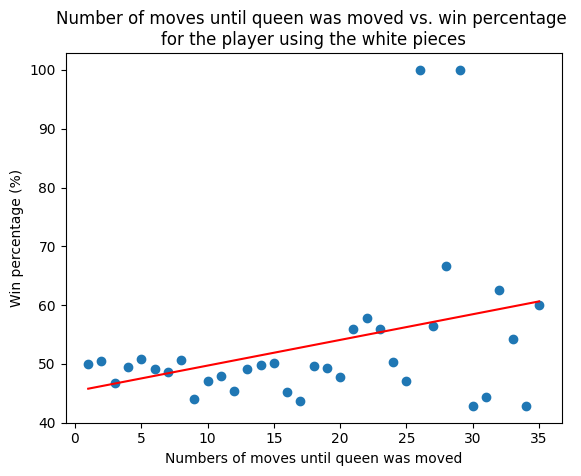

In [58]:
# Create scatter plot with number of moves before moving the queen
# on the x-axis and the win percentage of games played that way for white
# Calculate win percentage for each number of moves
white_win_perc = [100*float(white_qwp[key][0]/white_qwp[key][1]) for key in white_qwp]

# Sort the number of moves until queen moves
white_xvals = list(white_qwp.keys())
white_xvals.sort()
w_first35 = white_xvals[0:35]

w_first35_2D = np.array(w_first35).reshape((-1, 1))  # reshape data to fit x axis
# Fit linear regression line to the data
w_model = linreg().fit(w_first35_2D, white_win_perc[0:35])
w_preds = w_model.predict(w_first35_2D)
plt.scatter(w_first35, white_win_perc[0:35])
plt.plot(w_first35, w_preds, color='red')
# Set x and y labels and title
plt.xlabel('Numbers of moves until queen was moved')
plt.ylabel('Win percentage (%)')
plt.title('Number of moves until queen was moved vs. win percentage \nfor the player using the white pieces')
plt.show()

**Results:** We can see from the above scatter plot that there is a positve slope correlation between the number of moves until the queen was moved and the win percentage for players using white pieces. 

##Number of moves until queen was moved vs. win percentage for the player using the black pieces

Here we are creating a scatter plot with a regression line in order to visualize the relationship between the number of moves until the queen is moved and the win percentage of a player who is using white pieces. This graph provides us insight into whether there is a correlation between these factors. 

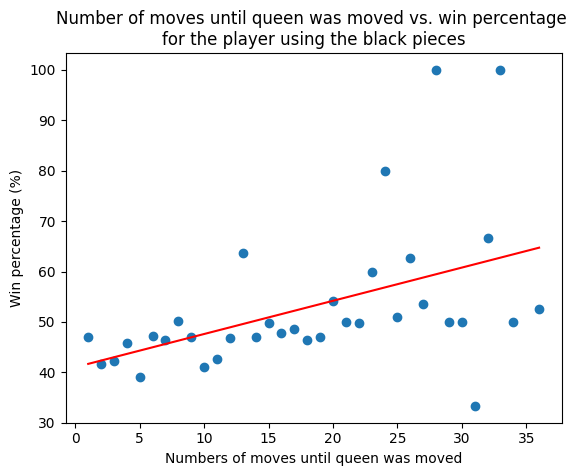

In [59]:
# Create scatter plot with number of moves before moving the queen
# on the x-axis and the win percentage of games played that way for black

# Calculate win percentage for each number of moves 
black_win_perc = [100*float(black_qwp[key][0]/black_qwp[key][1]) for key in black_qwp]

# sort the keys which are each number of moves
black_xvals = list(black_qwp.keys())
black_xvals.sort()
b_first35 = black_xvals[0:35]
b_first35_2D = np.array(b_first35).reshape((-1, 1))  # reshape data to fit x axis

# Fit linear regression line to data
b_model = linreg().fit(b_first35_2D, black_win_perc[0:35])
b_preds = b_model.predict(b_first35_2D)
plt.scatter(b_first35, black_win_perc[0:35])
plt.plot(b_first35, b_preds, color='red')
# Set x and y labels and title
plt.xlabel('Numbers of moves until queen was moved')
plt.ylabel('Win percentage (%)')
plt.title('Number of moves until queen was moved vs. win percentage \nfor the player using the black pieces')
plt.show()

**Results:** We can see from the graph that there is a positive correlation between the number of moves until the queen was moved and and the win percentage for players. The increase in win percentage seems to be more dramatic for the black pieces.

So, in general, it seems as if the longer a player waits to move the queen, the greater that player's chance of winning becomes.



---



##Residuals vs. Numbers of moves until queen was moved 

Here we calculate the residuals by subtracting the predicted values from the actual values and create a scatter plot to visualize the relationship between the number of moves until the queen is moved (x-axis) and the residuals (y-axis).  The residuals help us assess the deviation between the predicted and actual win percentages and provide insights into the accuracy of the regression model.

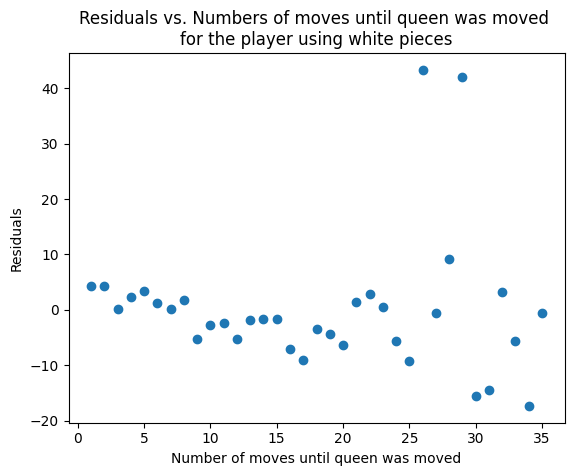

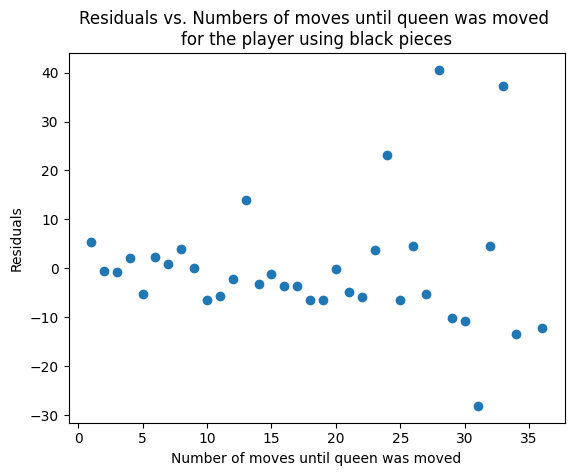

In [60]:
# Plot the residuals of all points in the previous scatter plot for white
w_residuals = []
for i, move in enumerate(w_first35):
  residual = white_win_perc[i] - w_preds[i]  # calculate residual
  w_residuals.append(residual)
# Plot residual data
plt.scatter(w_first35, w_residuals)
# Set x and y labels and title
plt.xlabel("Number of moves until queen was moved")
plt.ylabel('Residuals')
plt.title('Residuals vs. Numbers of moves until queen was moved \nfor the player using white pieces')
plt.show()

###########################################################################################################

# Plot the residuals of all points in the previous scatter plot for black
b_residuals = []
for i, move in enumerate(b_first35):
    residual = black_win_perc[i] - b_preds[i]  # calculate residual
    b_residuals.append(residual)
# Plot residual data
plt.scatter(b_first35, b_residuals)
# Set x and y labels and title
plt.xlabel("Number of moves until queen was moved")
plt.ylabel('Residuals')
plt.title('Residuals vs. Numbers of moves until queen was moved \nfor the player using black pieces')
plt.show()

**Results:** As seen from these two graphs the points are more closely centered around 0 for the black pieces than the residuals for the white pieces but both graphs have many points that are far from zero. This shows that the quicker the queen is moved the better the model is at predicting a win. This might indicate that the quicker the queen is moved then the more likely someone is to win the game.  



---



#Model: Analysis, Hypothesis Testing, & Machine Learning


###Ordinary Least Squares (OLS) Regression Analysis for Opening Name vs. White Win Percentage

We are curious as to how correlated the Opening Name is to white's win percentage. We decided to run an Ordinary Least Squares with the Opening Name being the independent variable and white's win percentage being the dependent variable. However, we first had to encode the opening names with a numerical value to properly fit the model, so each opening name got an index value.

####**Hypotheses**

*   *Null Hypothesis:* Opening name has no significant effect on win percentage

*   *Alternative Hypothesis:* Opening name has a significant effect on win percentage



In [61]:

# Add White_Win_Percentage column to our top_n_openings dataframe by dividing White_Wins column with Frequency column
top_n_openings_df['White_Win_Percentage'] = top_n_openings_df['White_Wins'] / top_n_openings_df['Frequency']
# Create Index column which gives each opening name its own numerical value
top_n_openings_df['opening_name_index'] = top_n_openings_df.index

# Run the OLS with Index as out independent variable and white_win_percentage as the dependent variable and print results
results = statapi.ols(formula="White_Win_Percentage ~ opening_name_index", data=top_n_openings_df).fit()

print("OLS Statistics for Win Percentage Compared to Opening Name")
print(results.summary())


OLS Statistics for Win Percentage Compared to Opening Name
                             OLS Regression Results                             
Dep. Variable:     White_Win_Percentage   R-squared:                       0.001
Model:                              OLS   Adj. R-squared:                 -0.019
Method:                   Least Squares   F-statistic:                   0.06378
Date:                  Fri, 12 May 2023   Prob (F-statistic):              0.802
Time:                          18:22:41   Log-Likelihood:                 47.286
No. Observations:                    50   AIC:                            -90.57
Df Residuals:                        48   BIC:                            -86.75
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

**Results:** As seen by the low R-squared values and high P-values it seems that opening names does not correlate significantly with the percentage of wins. Therefore, we fail to reject the null hypothesis.



###Ordinary Least Squares (OLS) Regression Analysis for Queen Movement Having Impact on Win Percentage

Here we are using an OLS regression model to examine the relationship between the movement of a queen and its effect on the win percentage. 

####**Hypotheses**

*   *Null Hypothesis:* when you move your queen has no significant effect on win percentage

*   *Alternative Hypothesis:* when you move your queen has a significant effect on win percentage










In [62]:
# Create DataFrame with the number of moves before moving the queen and the 
# associated win percentage for white
white_queen_wp_df = pd.DataFrame(columns=['Num_Moves', 'Win_Percentage'])
for i, moves in enumerate(w_first35):
    white_queen_wp_df.loc[i] = [moves, white_win_perc[i]]

# Use Ordinary Least Squares model to examine statistical significance of 
# moving the queen to win percentage
model2_w = statapi.ols(formula="Num_Moves ~ Win_Percentage", data=white_queen_wp_df).fit()

# print results of Ordinary Least Squares model
print(model2_w.summary())
print(f'\np-values: \n{model2_w.pvalues}')


                            OLS Regression Results                            
Dep. Variable:              Num_Moves   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     4.515
Date:                Fri, 12 May 2023   Prob (F-statistic):             0.0412
Time:                        18:22:41   Log-Likelihood:                -128.36
No. Observations:                  35   AIC:                             260.7
Df Residuals:                      33   BIC:                             263.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.3369      7.095      0.

####**White Queen Regression Results**


*   We see that the R-squared value is 0.120, this indicates that the model explains 12% of the variance in the number of moves.
*   The coefficient for Win_Percentage is 0.2756, meaning that a one-unit increase in the win percentage would be associated with a 0.2756 increase in the number of moves.
*   The p value for the Win_percentage is 0.041, which is below the significance level of 0.05. This means that there is enough evidence to reject the null hypothesis that the queen's movement has no significant impact on the win percentage.
---

We then did the same thing for black pieces by looking at the number of moves before the black queen was moved. We then did OLS regression.

####**Hypotheses**

*   *Null Hypothesis:* Opening name has no significant effect on win percentage

*   *Alternative Hypothesis:* Opening name has a significant effect on win percentage

In [63]:
# Create DataFrame with the number of moves before moving the queen and the 
# associated win percentage for black
black_queen_wp_df = pd.DataFrame(columns=['Num_Moves', 'Win_Percentage'])
for i, moves in enumerate(b_first35):
    black_queen_wp_df.loc[i] = [moves, black_win_perc[i]]

# Use Ordinary Least Squares model to examine statistical significance of 
# moving the queen to win percentage
model2_b = statapi.ols(formula="Num_Moves ~ Win_Percentage", data=black_queen_wp_df).fit()

# print results of Ordinary Least Squares model
print(model2_b.summary())
print(f'\np-values: \n{model2_b.pvalues}')

                            OLS Regression Results                            
Dep. Variable:              Num_Moves   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     9.272
Date:                Fri, 12 May 2023   Prob (F-statistic):            0.00455
Time:                        18:22:41   Log-Likelihood:                -126.44
No. Observations:                  35   AIC:                             256.9
Df Residuals:                      33   BIC:                             260.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4162      5.991      0.

####**Black Queen Regression Results**


*   We see that the R-squared value is 0.219, this indicates that the model explains 21.9% of the variance in the number of moves.
*   The coefficient for Win_Percentage is 0.3330, meaning that a one-unit increase in the win percentage would be associated with a 0.3330 increase in the number of moves.
*   The p value for the Win_percentage is 0.005, which is below the significance level of 0.05. This means that there is evidence to reject the null hypothesis that the queen's movement has no significant impact on the win percentage.

As the scatter plots showed, it seems that there is more of a correlation between black waiting to move their queen and winning than white.

---

This code segment performs an F-test on the regression model to test the joint significance of all the coefficients in the model. It uses the identity matrix as the hypothesis matrix.

The F-test result will provide information about the overall significance of the regression model. The output will include the F-statistic value, the corresponding p-value, and other relevant statistics.

In [64]:
print(model2_w.f_test(np.identity(len(model2_w.params)))) #F-test for white win percentage

<F test: F=61.83922896605605, p=6.8837762933996095e-12, df_denom=33, df_num=2>


In [65]:
print(model2_b.f_test(np.identity(len(model2_b.params)))) #F-test for black win percentage

<F test: F=71.33455436934842, p=1.0423316919946565e-12, df_denom=33, df_num=2>


**Results of F-test:** As seen from both F-tests the p-values are very low, effectively zero, which suggests there is strong evidence against the null hypothesis and strong evidence for the alternative hypothesis.


---





#ELO Rating & Bins

Now, we are curious about the effects of the opening that was played and ELO rating. An ELO rating is a numerical rating given to a chess player to dictate how strong of a chess player they are. For more information about ELO rating, visit https://www.hiarcs.com/hce-manual/pc/Eloratings.html. 

We have made 10 bins of ELO ratings from 700 points to 2700 to help capture games in seperate bins. The players in each of these bins have similar skill levels.



In [66]:
# Create a dictionary of dictionaries with ELO ranges (200 in length) as
# keys and the values being dictionaries with opening names as keys and 
# the number of times each opening is used by players that have and ELO
# rating within a particular range
elo_openings = {'700-900': {}, 
                '901-1100': {},
                '1101-1300': {},
                '1301-1500': {},
                '1501-1700': {},
                '1701-1900': {},
                '1901-2100': {},
                '2101-2300': {},
                '2301-2500': {},
                '2501-2700': {},
                }

for i, row in cleaned_dataset.iterrows():
    opening_name = row['opening_name']  # get the opening name
    white_elo = row['white_rating']  # get white's ELO rating
    black_elo = row['black_rating']  # get black's ELO rating
    # increment the proper dictionary value for white based on ELO rating
    # and opening name
    if 700 <= white_elo <= 900:
        elo_openings['700-900'].setdefault(opening_name, 0)
        elo_openings['700-900'][opening_name] += 1
    elif 901 <= white_elo <= 1100:
        elo_openings['901-1100'].setdefault(opening_name, 0)
        elo_openings['901-1100'][opening_name] += 1
    elif 1101 <= white_elo <= 1300:
        elo_openings['1101-1300'].setdefault(opening_name, 0)
        elo_openings['1101-1300'][opening_name] += 1
    elif 1301 <= white_elo <= 1500:
        elo_openings['1301-1500'].setdefault(opening_name, 0)
        elo_openings['1301-1500'][opening_name] += 1
    elif 1501 <= white_elo <= 1700:
        elo_openings['1501-1700'].setdefault(opening_name, 0)
        elo_openings['1501-1700'][opening_name] += 1     
    elif 1701 <= white_elo <= 1900:
        elo_openings['1701-1900'].setdefault(opening_name, 0)
        elo_openings['1701-1900'][opening_name] += 1
    elif 1901 <= white_elo <= 2100:
        elo_openings['1901-2100'].setdefault(opening_name, 0)
        elo_openings['1901-2100'][opening_name] += 1
    elif 2101 <= white_elo <= 2300:
        elo_openings['2101-2300'].setdefault(opening_name, 0)
        elo_openings['2101-2300'][opening_name] += 1
    elif 2301 <= white_elo <= 2500:
        elo_openings['2301-2500'].setdefault(opening_name, 0)
        elo_openings['2301-2500'][opening_name] += 1
    elif 2501 <= white_elo <= 2700:
        elo_openings['2501-2700'].setdefault(opening_name, 0)
        elo_openings['2501-2700'][opening_name] += 1
    # increment the proper dictionary value for black based on ELO rating
    # and opening name
    if 700 <= black_elo <= 900:
        elo_openings['700-900'].setdefault(opening_name, 0)
        elo_openings['700-900'][opening_name] += 1
    elif 901 <= black_elo <= 1100:
        elo_openings['901-1100'].setdefault(opening_name, 0)
        elo_openings['901-1100'][opening_name] += 1
    elif 1101 <= black_elo <= 1300:
        elo_openings['1101-1300'].setdefault(opening_name, 0)
        elo_openings['1101-1300'][opening_name] += 1
    elif 1301 <= black_elo <= 1500:
        elo_openings['1301-1500'].setdefault(opening_name, 0)
        elo_openings['1301-1500'][opening_name] += 1
    elif 1501 <= black_elo <= 1700:
        elo_openings['1501-1700'].setdefault(opening_name, 0)
        elo_openings['1501-1700'][opening_name] += 1     
    elif 1701 <= black_elo <= 1900:
        elo_openings['1701-1900'].setdefault(opening_name, 0)
        elo_openings['1701-1900'][opening_name] += 1
    elif 1901 <= black_elo <= 2100:
        elo_openings['1901-2100'].setdefault(opening_name, 0)
        elo_openings['1901-2100'][opening_name] += 1
    elif 2101 <= black_elo <= 2300:
        elo_openings['2101-2300'].setdefault(opening_name, 0)
        elo_openings['2101-2300'][opening_name] += 1
    elif 2301 <= black_elo <= 2500:
        elo_openings['2301-2500'].setdefault(opening_name, 0)
        elo_openings['2301-2500'][opening_name] += 1
    elif 2501 <= black_elo <= 2700:
        elo_openings['2501-2700'].setdefault(opening_name, 0)
        elo_openings['2501-2700'][opening_name] += 1

# Print out the top five openings used by players in each ELO range
for elo_range, ops in elo_openings.items():
    sorted_openings = sorted(ops.items(), key=lambda x:x[1], reverse=True)
    print(f'Top 5 Openings for ELO Range {elo_range}')
    for i, (opening, freq) in enumerate(sorted_openings[:5]):
        print(f'{i + 1}. {opening}')
    print()

Top 5 Openings for ELO Range 700-900
1. King's Pawn Game: Leonardis Variation
2. Scandinavian Defense
3. Sicilian Defense: Bowdler Attack
4. Van't Kruijs Opening
5. Hungarian Opening: Symmetrical Variation

Top 5 Openings for ELO Range 901-1100
1. Van't Kruijs Opening
2. Scandinavian Defense
3. King's Pawn Game: Wayward Queen Attack
4. French Defense: Knight Variation
5. Horwitz Defense

Top 5 Openings for ELO Range 1101-1300
1. Van't Kruijs Opening
2. Scandinavian Defense
3. King's Pawn Game: Wayward Queen Attack
4. Scandinavian Defense: Mieses-Kotroc Variation
5. Sicilian Defense

Top 5 Openings for ELO Range 1301-1500
1. Van't Kruijs Opening
2. Sicilian Defense
3. Scandinavian Defense: Mieses-Kotroc Variation
4. Sicilian Defense: Bowdler Attack
5. Scotch Game

Top 5 Openings for ELO Range 1501-1700
1. Sicilian Defense: Bowdler Attack
2. Scotch Game
3. Sicilian Defense
4. French Defense: Knight Variation
5. Caro-Kann Defense

Top 5 Openings for ELO Range 1701-1900
1. Sicilian Defense

**Results:** Above are printed the top 5 openings for each ELO range. Some notable trends are that the first 6 ranges, the lower rated players, all use similar openings, with little variation between each of them. Then, the last several ranges, the more highly rated players, use different openings than the first lower ranges. Furthermore, the openings used at the highest ranges are include more variations and are more complex. This makes sense because higher rated players must have more experience and are able to play more complicated openings.

***A Visualization of Openings Used By Each ELO Range***

Previously, we saw the top 5 openings for each ELO range, but that didn't give the clearest picture of the overal opening usage for each range. Next, we visualize the openings used by each ELO range.

To best show proportions, we chose to visualize our data using pie charts. The following pie charts include all openings used by players in each ELO range.

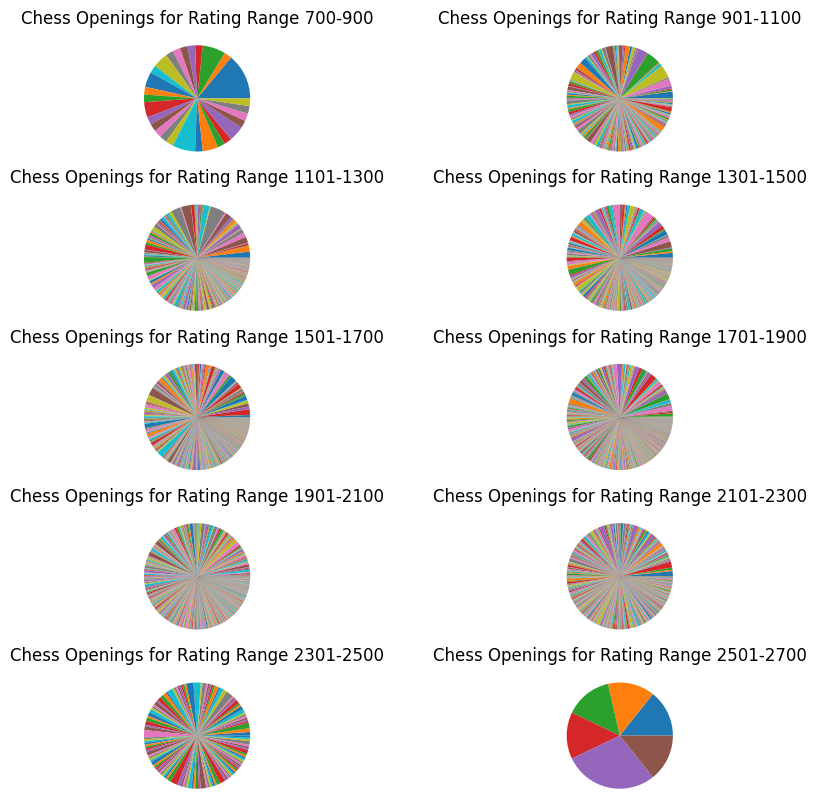

In [67]:
# Iterate over the elo_openings dictionary and make a pie chart showing the 
# proportion of players that use each opening in each ELO range
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
axs = axs.flatten()
for i, (rating_range, opening_freqs) in enumerate(elo_openings.items()):
    ops = []
    frequencies = []

    #Gathers all openings for particular range of ELOs
    for opening, frequency in opening_freqs.items():
        ops.append(opening)
        frequencies.append(frequency)

    axs[i].pie(frequencies)
    axs[i].set_title("Chess Openings for Rating Range {}".format(rating_range))
plt.show()

**Results:** The most notable aspect of the pie charts created above is the diversity of openings and how many there are. The lower rating ranges have bigger "pie slices" because fewer openings are played by those players. This is most likely because the lower rated players use simpler openings that are easier to understand. The general trend is that the higher the players are rated, the more different openings they use (ie. more variations). This trend seems to reverse at the highest rated ranges of players which is likely resulting from the fact that there are less games in our dataset played by 2501-2700.

***Win Percentages by ELO Rating Grouped by ELO Range***

Next, we want to visualize the win percentages for each opening used by players in each ELO range. We are curious as to whether or not a bigger ELO disparity results in more wins for the player with a higher ELO rating. To do this, we use the dictionary *elo_openings* used to make the above pie charts and cross reference the openings from this dictionary with the master *openings* dictionary, which contains the win percentage data needed.

For the purpose of readability, only openings from the top 50 openings are included for ranges in which the number of openings played is greater than 100.

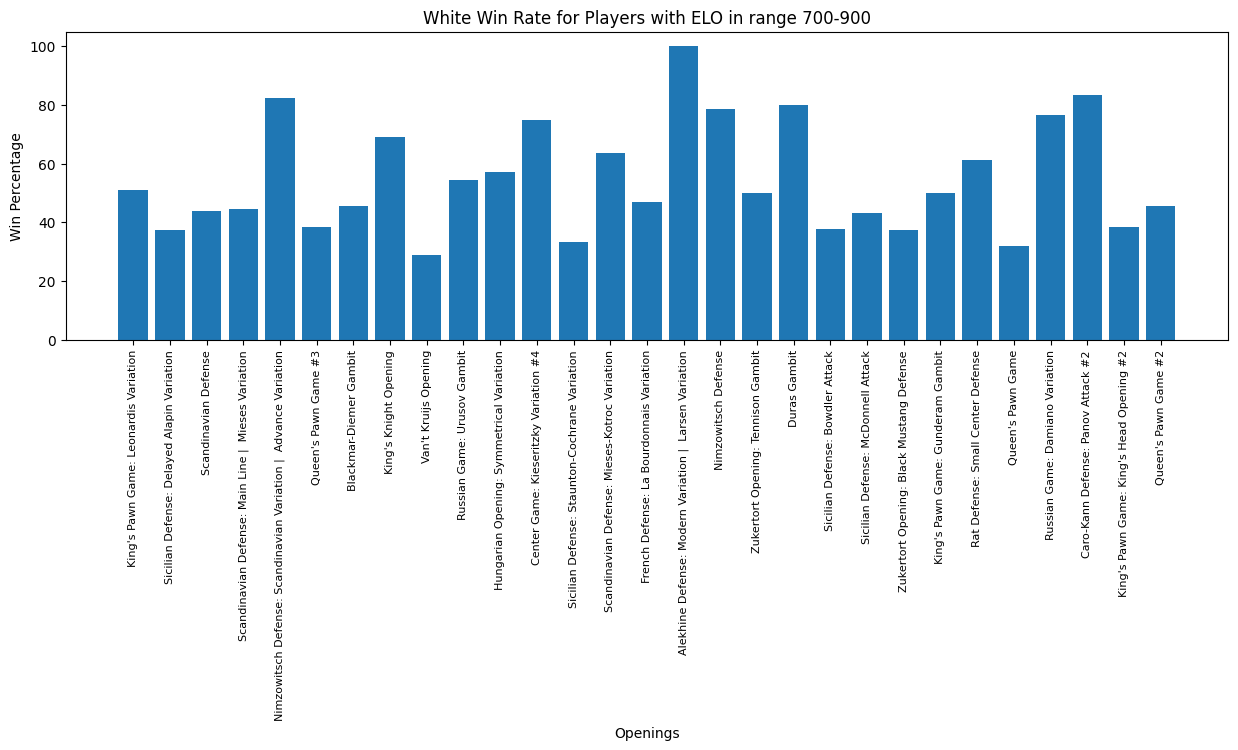

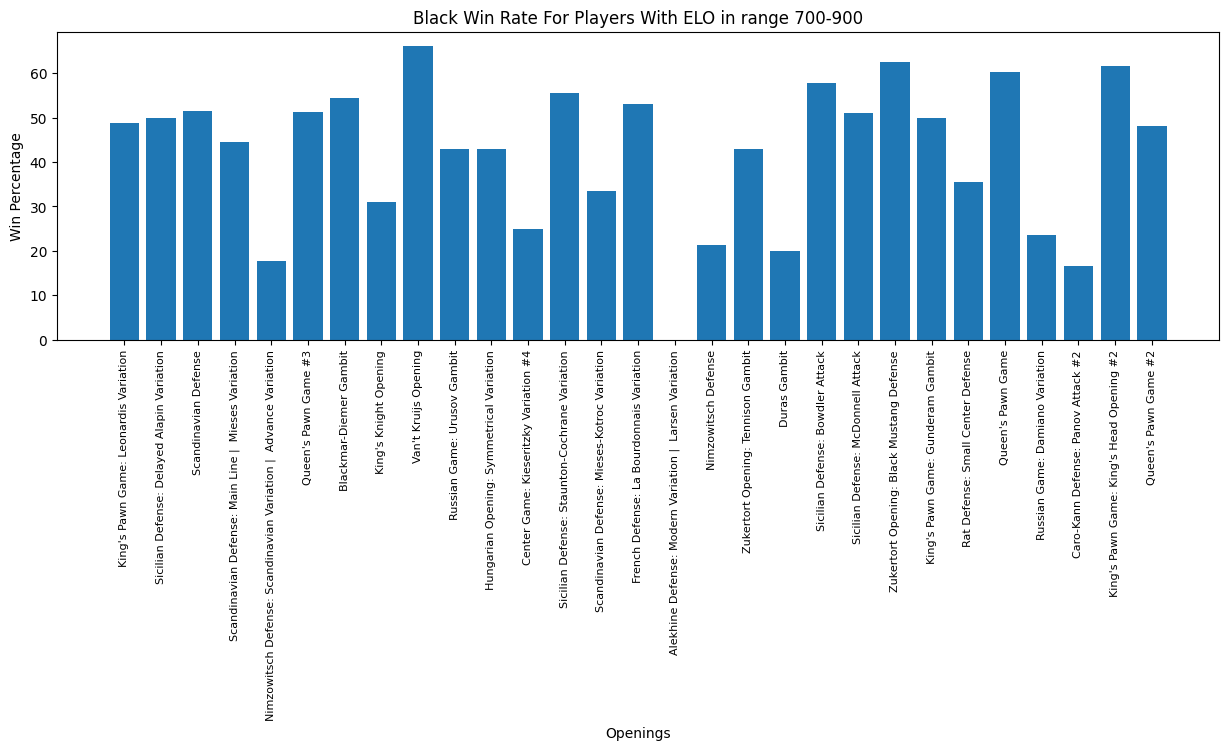

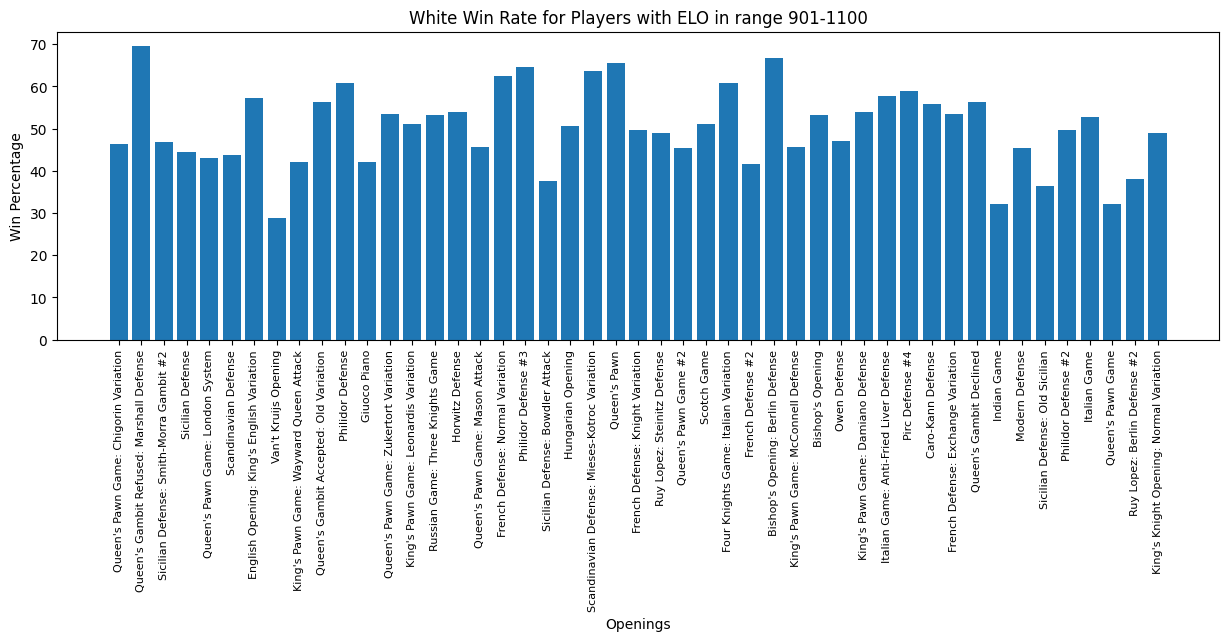

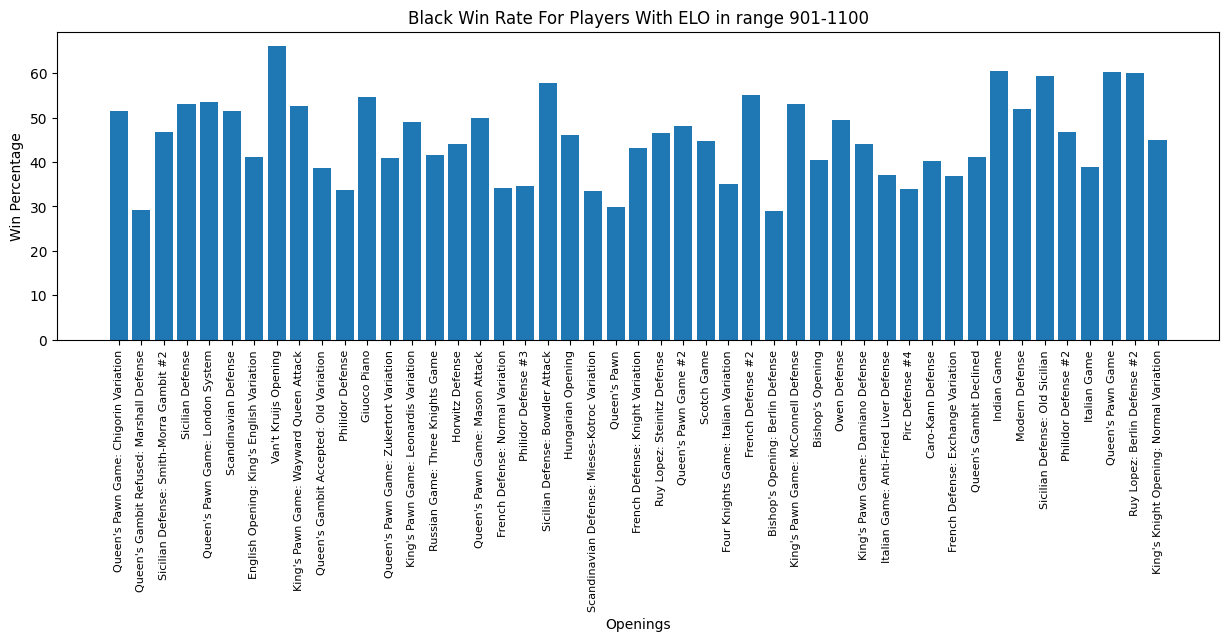

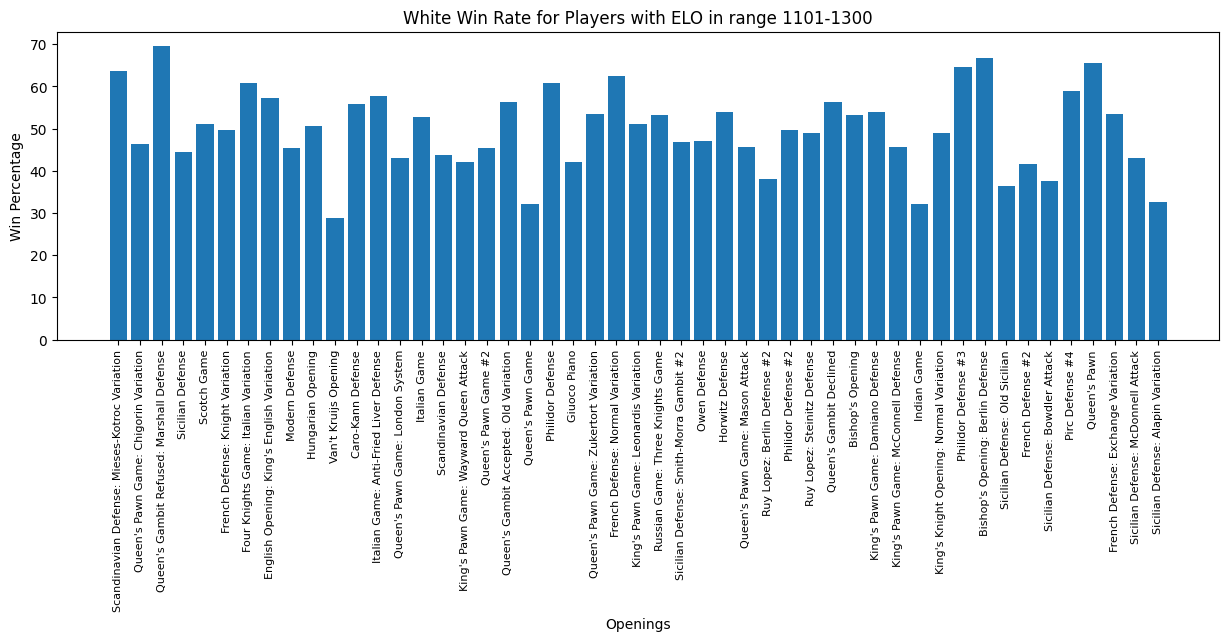

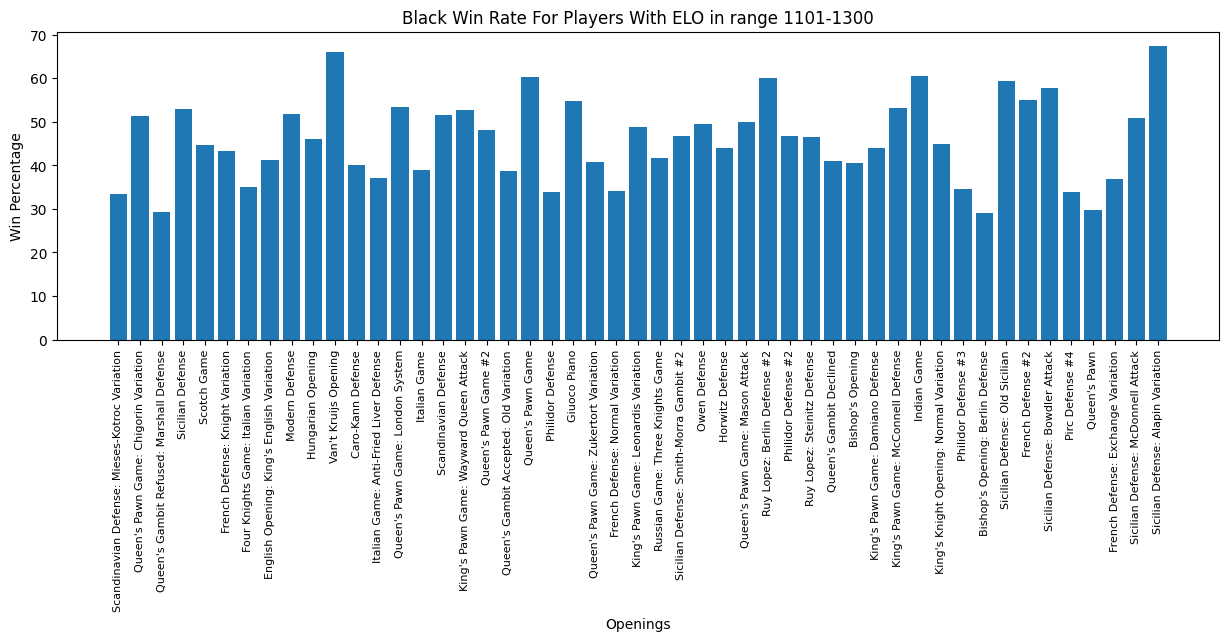

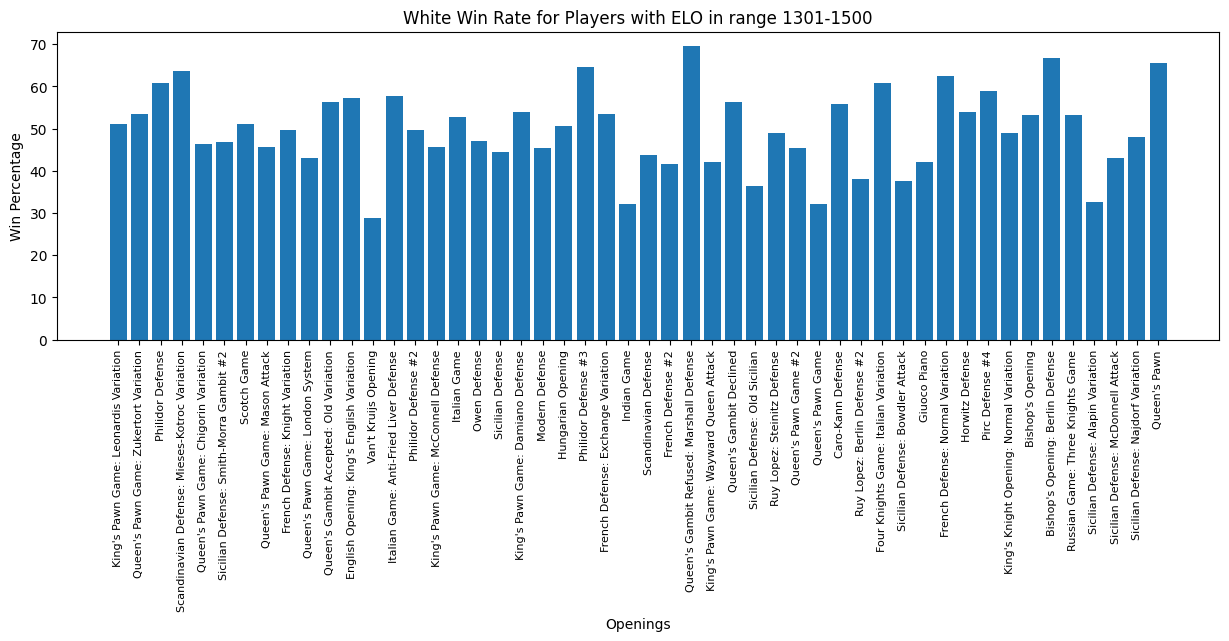

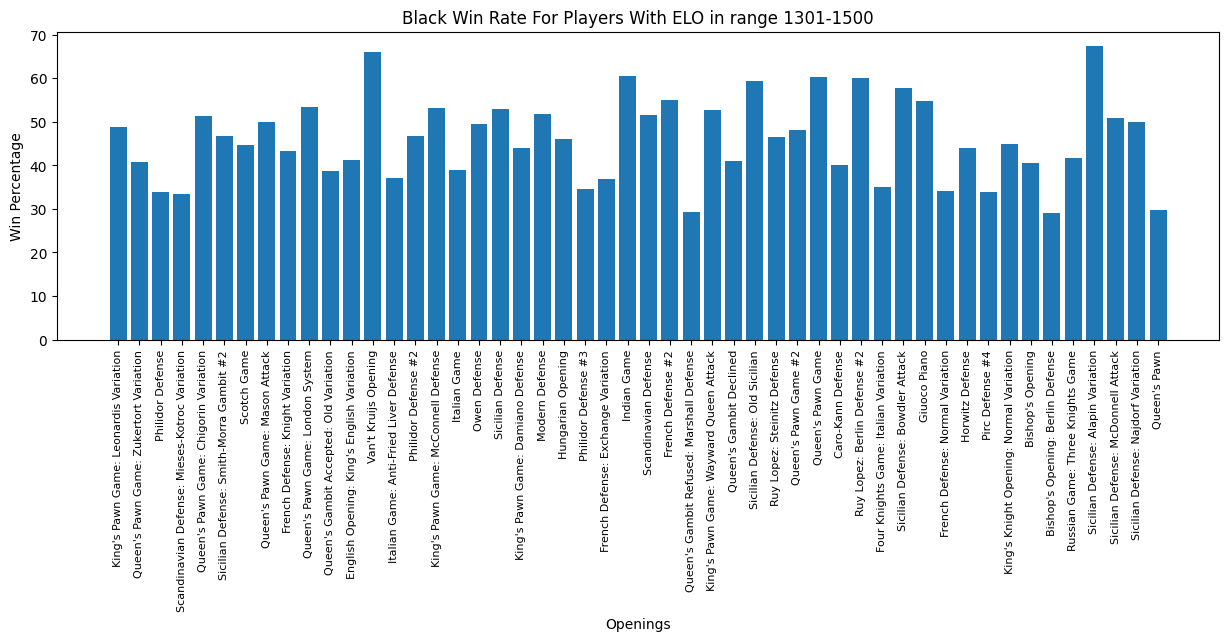

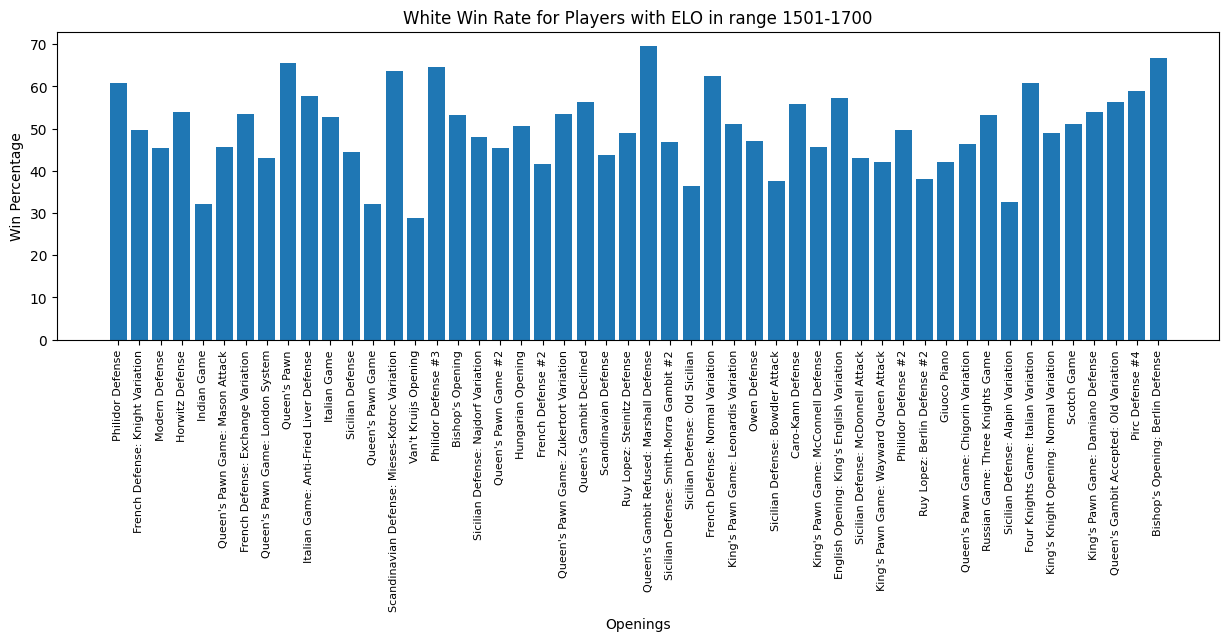

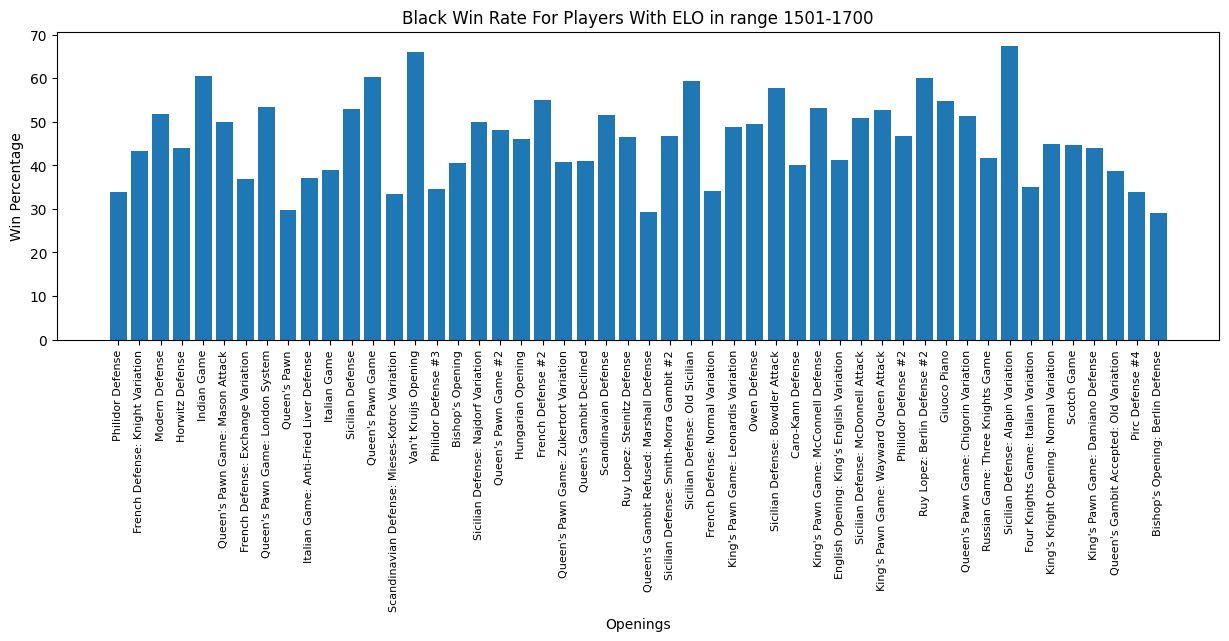

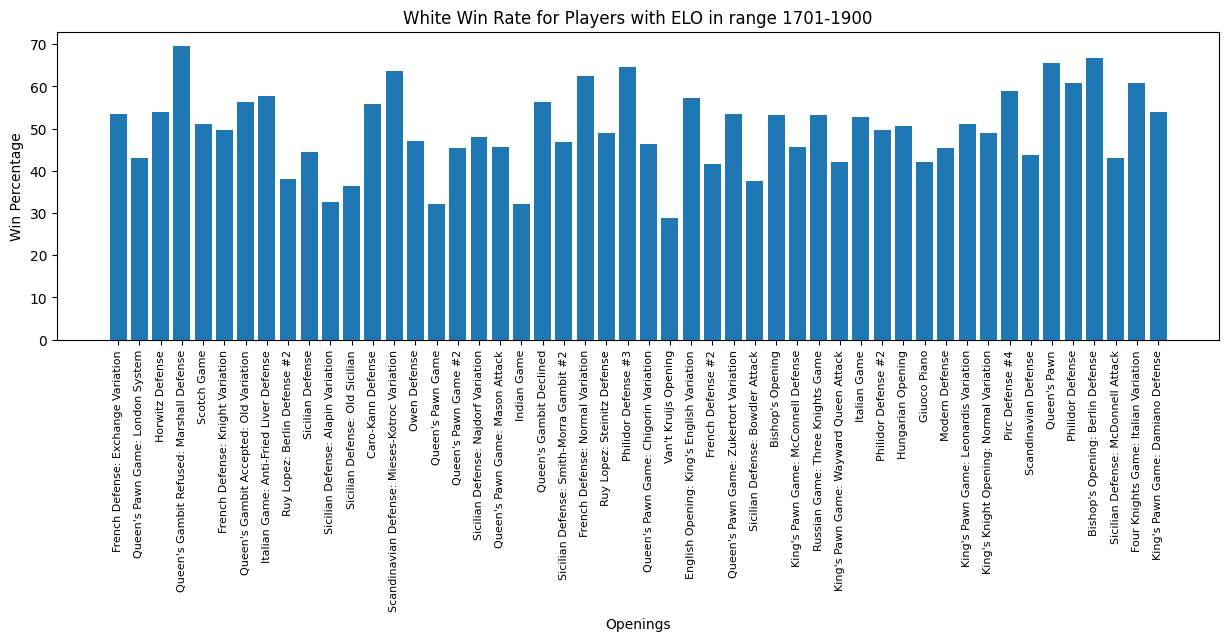

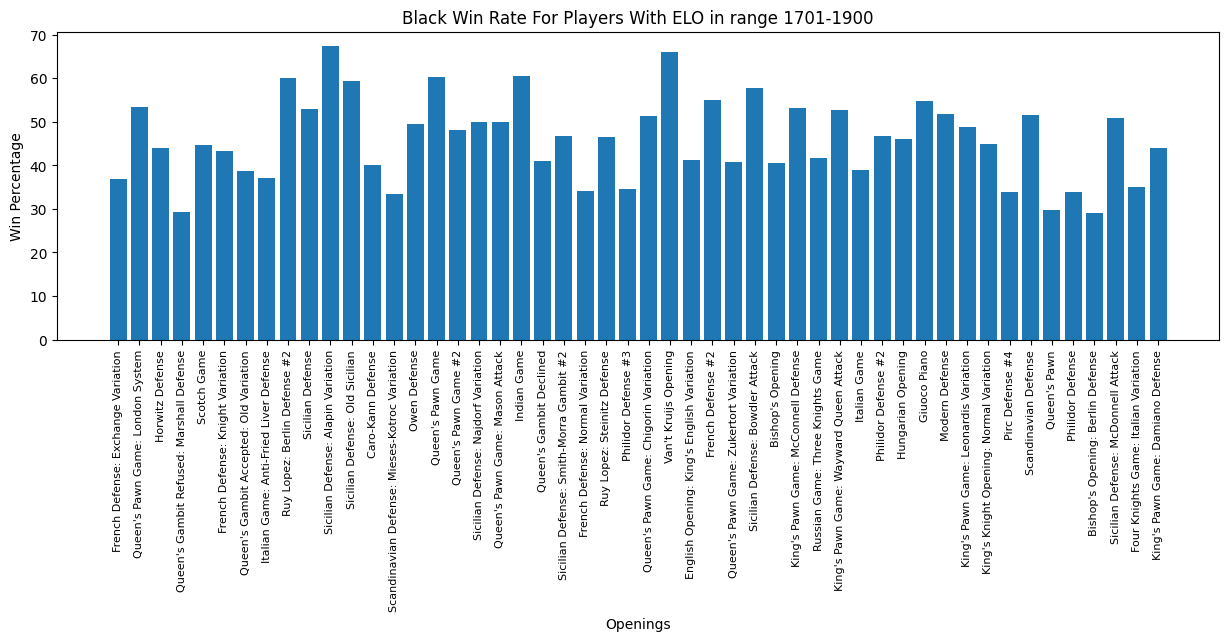

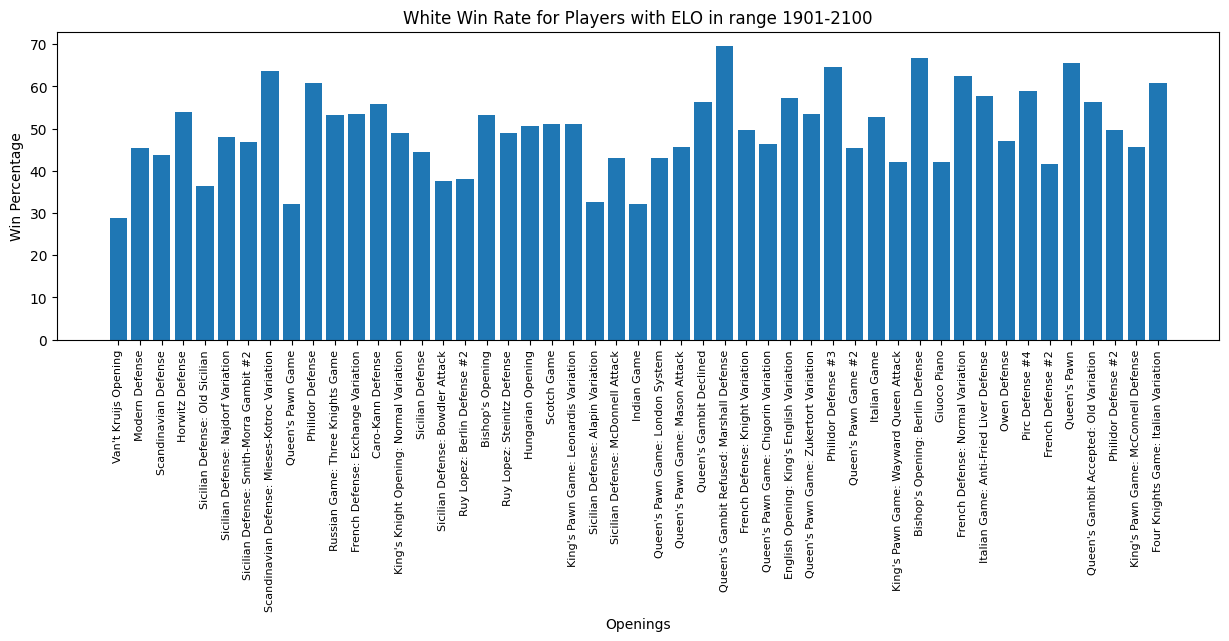

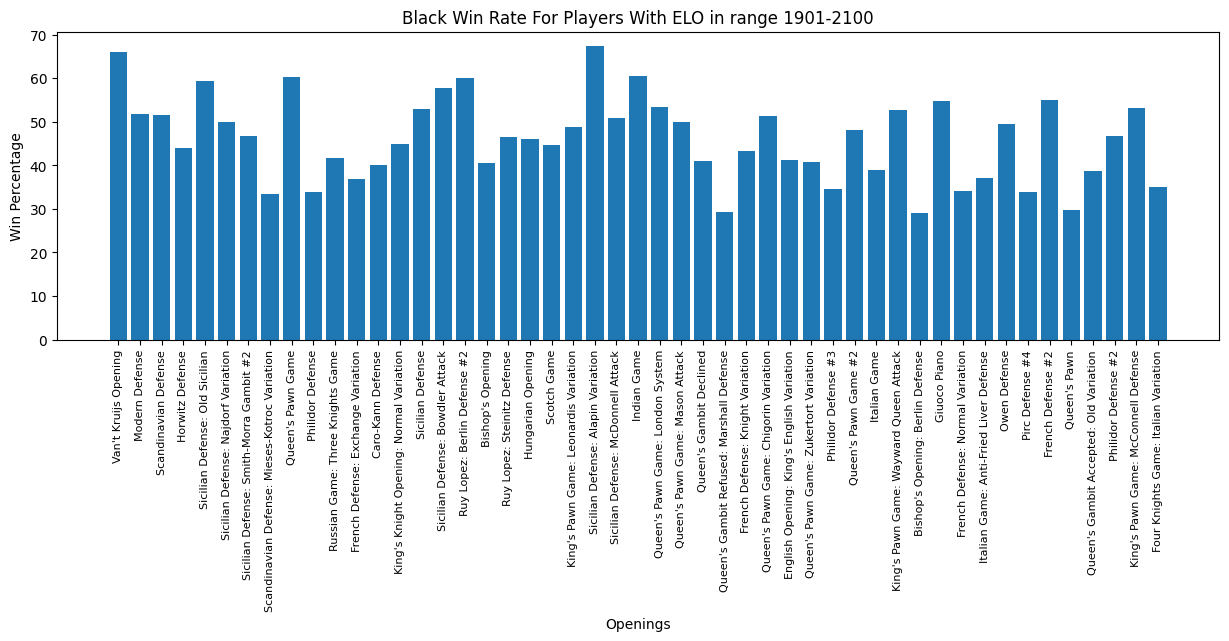

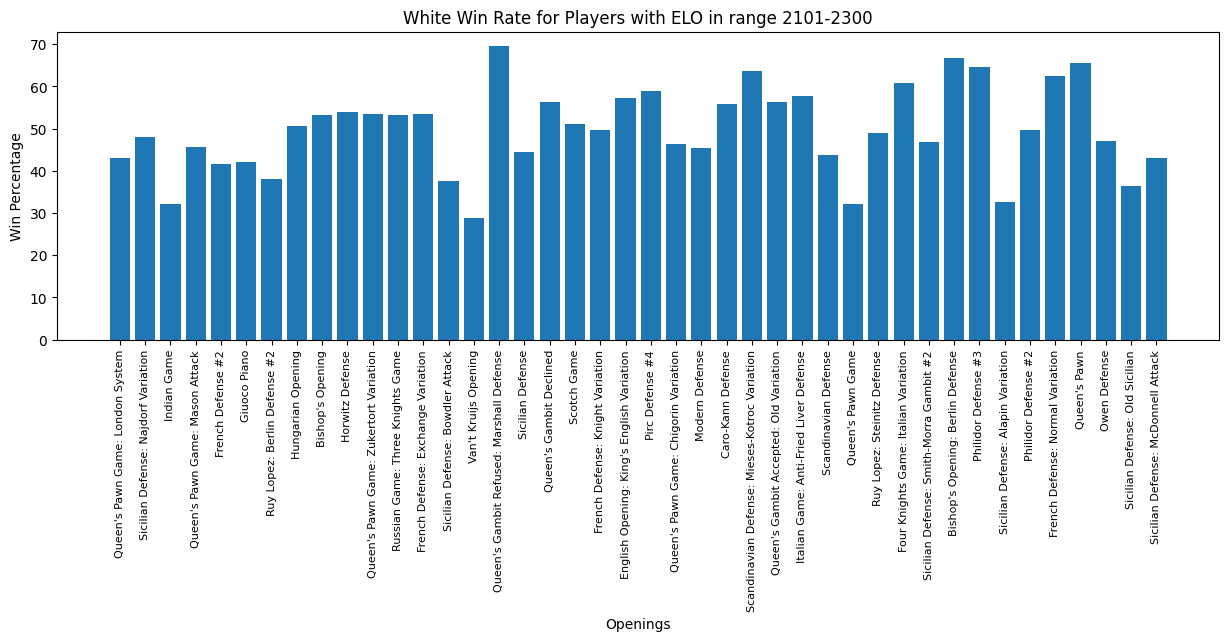

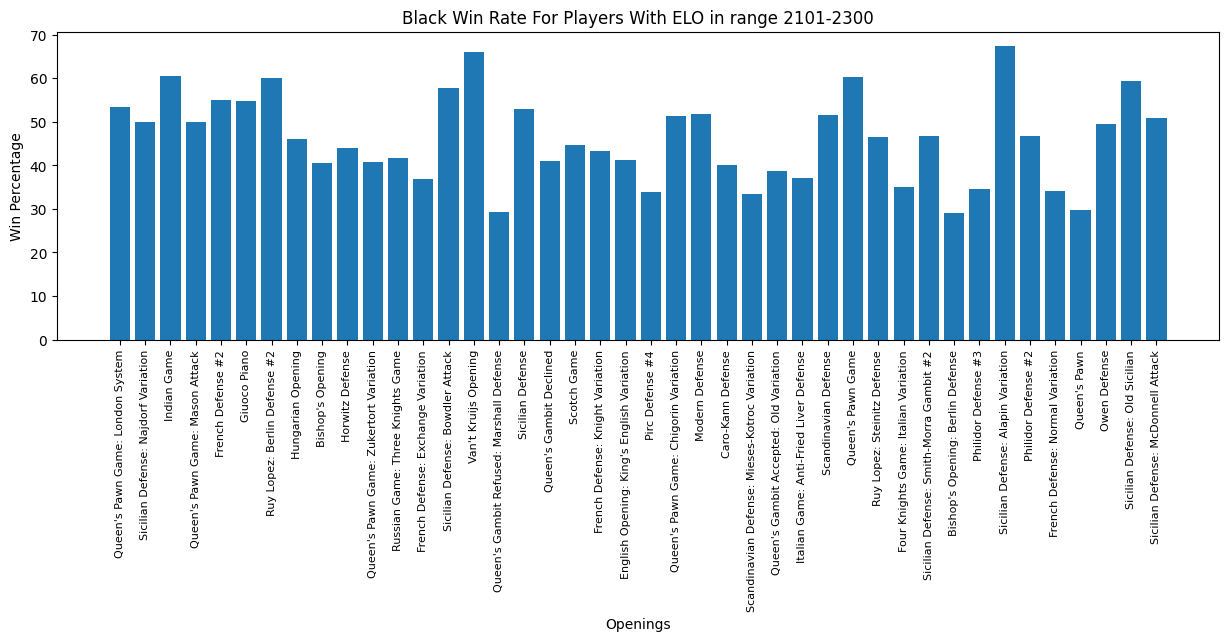

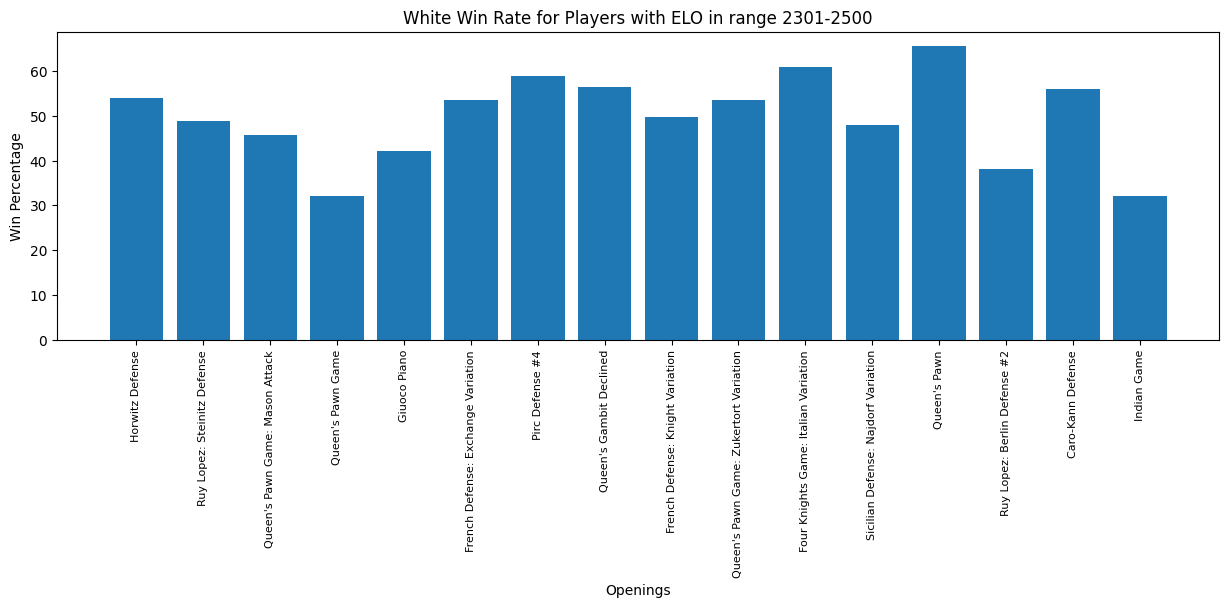

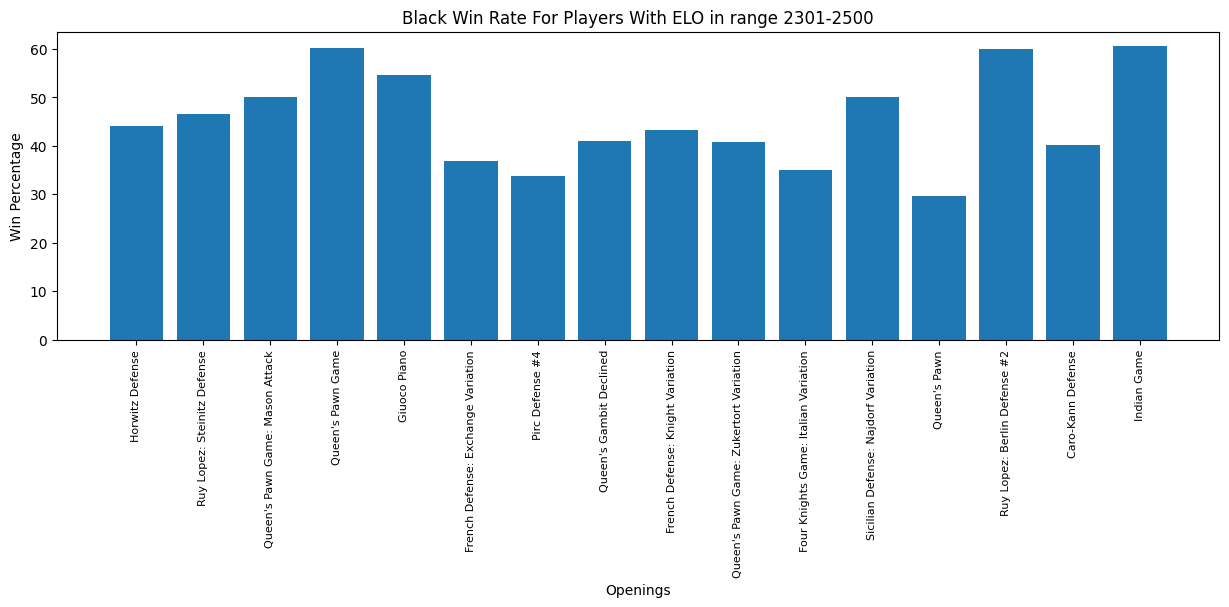

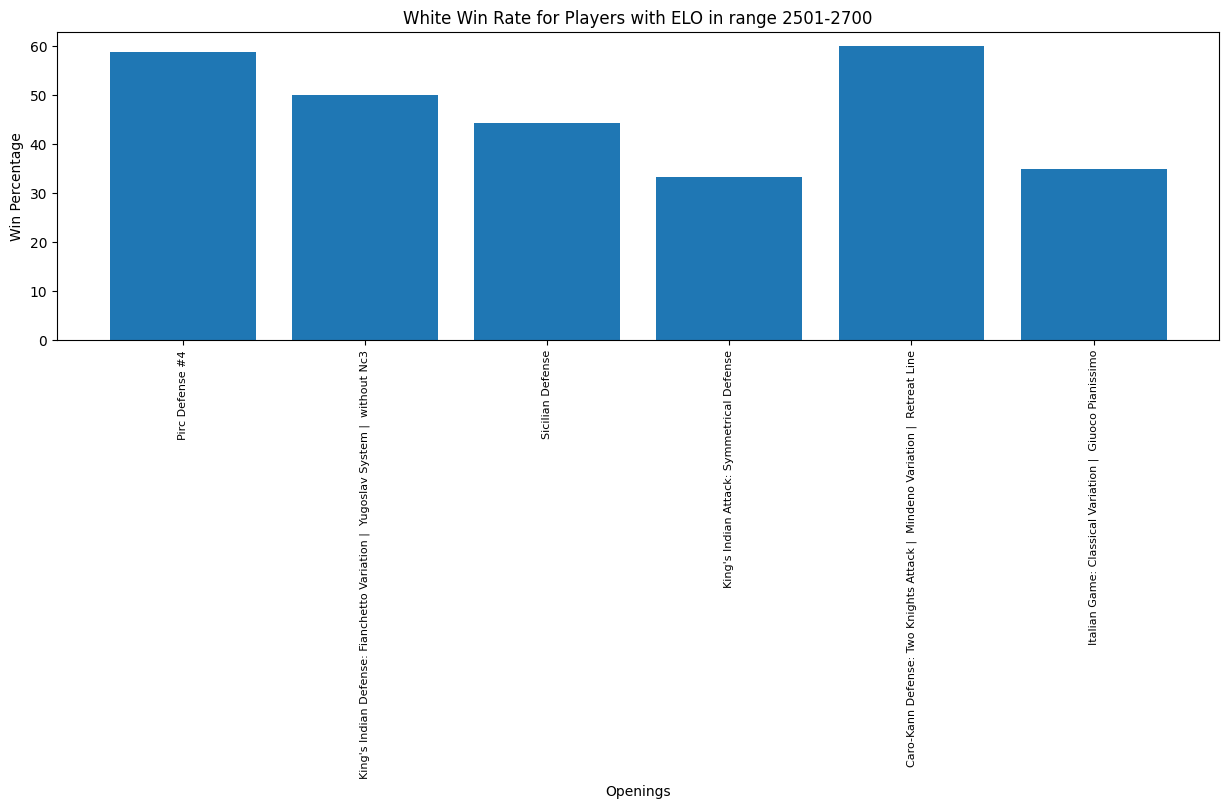

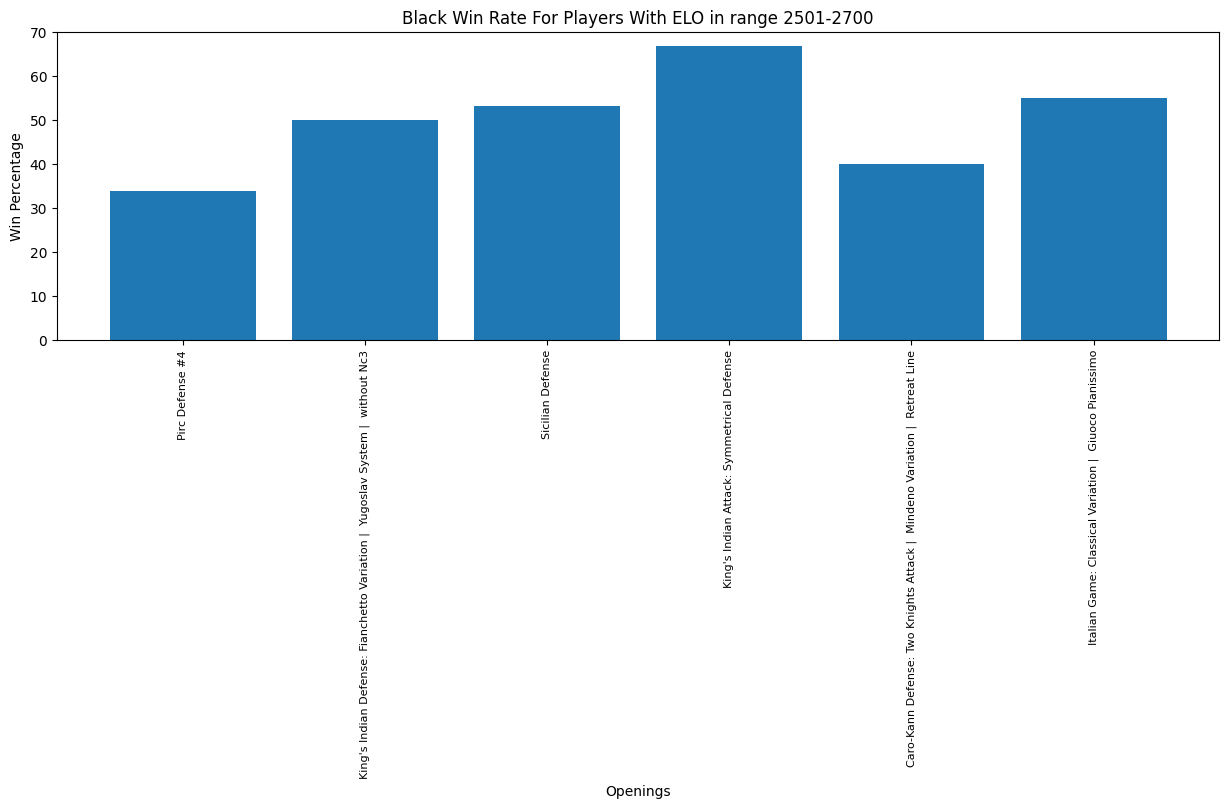

In [68]:
# Create histograms for each ELO range showing the win percentages of the 
# openings used by each player
# 10 ranges x 2 players = 20 histograms
for rating_range, opening_freqs in elo_openings.items():
    ops = []
    white_win_percs = []
    black_win_percs = []
    
    # Get the openings and frequencies for this rating range
    if len(opening_freqs.keys()) > 100:
        # if there are more than 100 openings, only take ones from the top 50
        for opening, frequency in opening_freqs.items():
            top_openings = [tup[0] for tup in top_n_openings]
            if opening in top_openings:
                ops.append(opening)
                eco, (white, black, tie, freq) = openings[opening]
                # calculate win percentages
                white_win_percs.append(100 * (float(white) / float(freq)))
                black_win_percs.append(100 * (float(black) / float(freq)))
    else: 
        for opening, frequency in opening_freqs.items():
            ops.append(opening)
            eco, (white, black, tie, freq) = openings[opening]
            # calculate win percentages
            white_win_percs.append(100 * (float(white) / float(freq)))
            black_win_percs.append(100 * (float(black) / float(freq)))

    # Create Histogram for White
    fig_w, ax_w = plt.subplots(figsize=(15,4))
    ax_w.bar(ops, white_win_percs)
    # Properly format ticks on the x-axis
    ax_w.set_xticklabels(ops, rotation=90)
    plt.xticks(fontsize=8)
    # Set axis labels and title
    ax_w.set_xlabel('Openings')
    ax_w.set_ylabel('Win Percentage')
    ax_w.set_title(f'White Win Rate for Players with ELO in range {rating_range}')
    plt.show()
    
    # Create Histogram for Black
    fig_b, ax_b = plt.subplots(figsize=(15,4))
    ax_b.bar(ops, black_win_percs)
   # Properly format ticks on the x-axis
    ax_b.set_xticklabels(ops, rotation=90)
    plt.xticks(fontsize=8)
    # Set axis labels and title
    ax_b.set_xlabel('Openings')
    ax_b.set_ylabel('Win Percentage')
    ax_b.set_title(f'Black Win Rate For Players With ELO in range {rating_range}')
    plt.show()

**Results:** These bar graphs show the most effective openings for both players in each ELO range. These are valuable insights for players who are looking to improve their game. No matter what ELO a player is at, these graphs show the best openings that they can use.

*As we get to highest ratings, we see that there are only six openings being played. This is a result of not having many high rated games as data points that qualify in our clean dataset.*



---


**ELO Rating and Opening Name**

We created a dataframe containing columns for: White's ELO, Black's ELO, Opening Name, Opening Win Rate for White, Opening Win Rate for Black, Draw Rate for the Opening, White Result, Black Result, Number of moves until black queen was moved, and Number of moves until white queen was moved. Each row of the dataframe contains the information for every game that takes place from our cleaned_dataset. We will use this dataframe that we call "ratings_and_openings" to examine the effect that a player's ELO, opening, and the number of moves until the queen was moved has on whether they win or not.

In [69]:
# Create DataFrame housing data for each game including the win rates for each
# player, the draw rate, and a 1 or 0 to denote the winner in columns for each
# player
ratings_and_openings = pd.DataFrame(columns=['White_ELO', 'Black_ELO', 'Opening_Name', 'Opening_Win_Rate_W', 'Opening_Win_Rate_B', 'Draw_Rate', 'White_Win', 'Black_Win', "num_moves_until_black_queen", "num_moves_until_white_queen"])

for i, row in cleaned_dataset.iterrows():
    w_queen_count = 0
    b_queen_count = 0
    w_q_flag = False
    b_q_flag = False
    # Iterate through the moves to count how long it took for queen to be moved
    for j, m in enumerate(row['moves'].split()):
      if j % 2 == 0:
        if m[0] == 'Q' and w_q_flag == False:
          w_q_flag = True
        else:
          if w_q_flag == False:
              w_queen_count += 1
      else:
        if m[0] == 'Q' and b_q_flag == False:
            b_q_flag = True
        else:
          if b_q_flag == False:
              b_queen_count += 1
    
    white_elo = row['white_rating']  # get white's rating
    black_elo = row['black_rating']  # get black's rating
    opening_name = row['opening_name']  # get the opening name
    winner = row['winner']  # get the outcome of the game
    white_win = 1 if winner == 'white' else 0  # keep track of white's win
    black_win = 1 if winner == 'black' else 0  # keep track of black's win
    # get the win percentage associated with the current opening for white
    white_wins = openings[opening_name][1][0]
    # get the win percentage associated with the current opening for black
    black_wins = openings[opening_name][1][1]
    # get the total number of games where the current opening is played
    game_freq = openings[opening_name][1][3]
    # calculate win rate for white
    opening_wrate_W = white_wins / game_freq
    # calculate win rate for black
    opening_wrate_B = black_wins / game_freq
    # calculate draw rate using white and black win rates
    draw_rate = 1 - opening_wrate_B - opening_wrate_W
    # only include openings that were used in at least 25 games
    if game_freq >= 25:
      ratings_and_openings.loc[i] = [white_elo, black_elo, opening_name, opening_wrate_W, opening_wrate_B, draw_rate, white_win, black_win, b_queen_count, w_queen_count]
display(ratings_and_openings)

,White_ELO,Black_ELO,Opening_Name,Opening_Win_Rate_W,Opening_Win_Rate_B,Draw_Rate,White_Win,Black_Win,num_moves_until_black_queen,num_moves_until_white_queen
2,1496,1500,King's Pawn Game: Leonardis Variation,0.511111,0.488889,0.000000,1,0,13,24
3,1439,1454,Queen's Pawn Game: Zukertort Variation,0.535211,0.408451,0.056338,1,0,5,13
4,1523,1469,Philidor Defense,0.608108,0.337838,0.054054,1,0,10,12
9,1381,1209,Scandinavian Defense: Mieses-Kotroc Variation,0.636364,0.335227,0.028409,1,0,1,9
25,1078,1219,Queen's Pawn Game: Chigorin Variation,0.464286,0.514286,0.021429,1,0,9,7
...,...,...,...,...,...,...,...,...,...,...
20048,1252,1233,French Defense: Exchange Variation,0.535714,0.369048,0.095238,1,0,2,6
20051,1237,1231,French Defense: Knight Variation,0.497297,0.432432,0.070270,0,1,4,22
20054,1233,1196,Queen's Pawn,0.654762,0.297619,0.047619,0,1,14,19
20055,1219,1286,Queen's Pawn Game: Mason Attack,0.456790,0.500000,0.043210,1,0,14,10


#Win Rate By ELO Difference

Another feature we wanted to examine was the impact that ELO difference had on the outcome of a game. We wanted to see how often the underdog player beat the higher rated player. We analyzed this from the perspectives of the white player and the black player and visualized them in the bar graphs below.



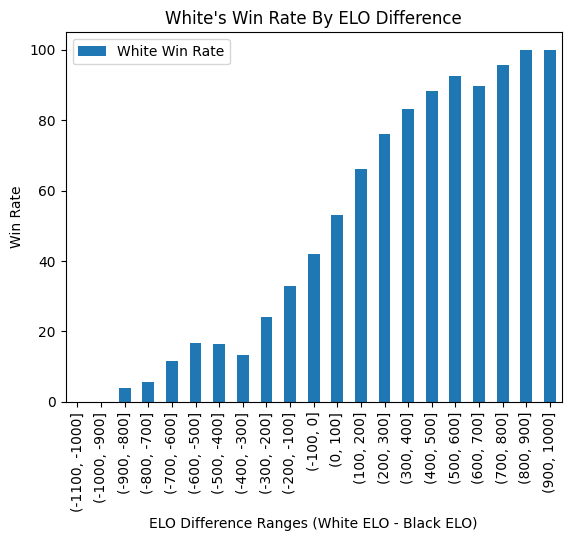

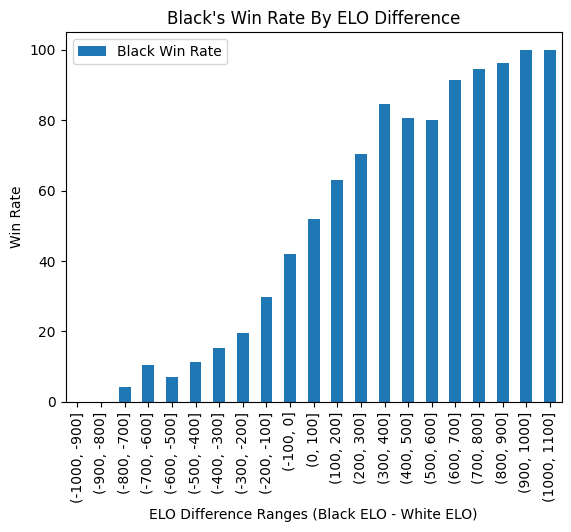

In [70]:
white_elo_diff_wrate = {}
black_elo_diff_wrate = {}
# loop through every row to calculate the ELO difference for each game

#Iterate through the ratings and openings to determine the difference in ELO rating.
for i, row in ratings_and_openings.iterrows():
    w_elo_diff = row['White_ELO'] - row['Black_ELO']
    white_won = row['White_Win']
    black_won = row['Black_Win']
    b_elo_diff = -1 * w_elo_diff
    white_elo_diff_wrate.setdefault(w_elo_diff, [0, 0])
    black_elo_diff_wrate.setdefault(b_elo_diff, [0, 0])
    white_elo_diff_wrate[w_elo_diff][0] += 1 if white_won else 0
    black_elo_diff_wrate[b_elo_diff][0] += 1 if black_won else 0
    white_elo_diff_wrate[w_elo_diff][1] += 1
    black_elo_diff_wrate[b_elo_diff][1] += 1

# Sort the keys which are the elo differences
white_sorted_keys = sorted(list(white_elo_diff_wrate.keys()))
black_sorted_keys = sorted(list(black_elo_diff_wrate.keys()))

#Make the bins to hold ELO ratings for both black and white
white_bins = pd.cut(white_sorted_keys, bins=range(-1100, 1100, 100))
black_bins = pd.cut(black_sorted_keys, bins=range(-1000, 1200, 100))

#Calculate win rates for both black and white
white_wrate = [100 * (white_elo_diff_wrate[key][0] / white_elo_diff_wrate[key][1]) for key in white_sorted_keys]
black_wrate = [100 * (black_elo_diff_wrate[key][0] / black_elo_diff_wrate[key][1]) for key in black_sorted_keys]

#Make the pandas dataframe to hold the rating difference and win respective win rate
new_white_df = pd.DataFrame({'White Rating Diff': white_sorted_keys, 'White Win Rate': white_wrate})
new_black_df = pd.DataFrame({'Black Rating Diff': black_sorted_keys, 'Black Win Rate': black_wrate})
white_result = new_white_df.groupby(white_bins)['White Win Rate'].mean()
black_result = new_black_df.groupby(black_bins)['Black Win Rate'].mean()

# display(new_white_df)
# display(new_black_df.head())

white_result = white_result.to_frame()
black_result = black_result.to_frame()

white_result.plot.bar()
plt.title('White\'s Win Rate By ELO Difference')
plt.xlabel('ELO Difference Ranges (White ELO - Black ELO)')
plt.ylabel('Win Rate')
plt.show()

black_result.plot.bar()
plt.title('Black\'s Win Rate By ELO Difference')
plt.xlabel('ELO Difference Ranges (Black ELO - White ELO)')
plt.ylabel('Win Rate')
plt.show()

**Results:** When examining the following bar graphs it is evident that whether someone is playing as black or white if they have a higher ELO rating than their opponent then their win rate is greater than 50%. It was found that when a player's ELO is about 900 points greater than their opponent then they have a 100% chance of winning the game. This makes sense because someone with an ELO 900 points higher than their opponent is likely to have more experience, played longer, and understands more strategy to help them win. On the flip side when someone has an ELO lower than their opponent, regardless of the color they are playing as, their win rate significantly drops.


---



#More Hypothesis Testing

We wanted to examine the statistics around ELO differences and win rates. After collecting the data we needed to create an OLS model, we came up with the following null and alternative hypothesis:

**Null Hypothesis:** ELO difference does not have a statistically significant effect on win rate for either player.

**Alternative Hypothesis:** ELO difference does have a statistically significant effect on win rate for either player.




In [71]:
bin_edges = white_result.index.categories
midpoints = bin_edges.mid

# Define the predictor variable and response variable
X = midpoints
y = white_result['White Win Rate']

# Add a constant term to the predictor variable
X = statsmodels.api.add_constant(X)

# Fit the OLS model
ols_model = statsmodels.api.OLS(y, X).fit()
print("Ordinary Least Square for White ELO difference and win rate")
# Print the model summary
print(ols_model.summary())

########################################################################

bin_edges = black_result.index.categories
midpoints = bin_edges.mid

# Define the predictor variable and response variable
X = midpoints
y = black_result['Black Win Rate']

# Add a constant term to the predictor variable
X = statsmodels.api.add_constant(X)

# Fit the OLS model
ols_model = statsmodels.api.OLS(y, X).fit()

print("\nOrdinary Least Square for Black ELO difference and win rate")
# Print the model summary
print(ols_model.summary())

Ordinary Least Square for White ELO difference and win rate
                            OLS Regression Results                            
Dep. Variable:         White Win Rate   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     403.5
Date:                Fri, 12 May 2023   Prob (F-statistic):           2.94e-14
Time:                        18:24:14   Log-Likelihood:                -73.198
No. Observations:                  21   AIC:                             150.4
Df Residuals:                      19   BIC:                             152.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

**Results for white win rate**

As seen above the P-value is 0.000 which is below the alpha of 0.05 therefore we reject the null hypothesis. The R<sup>2</sup> is 0.955 which means that 95.5% of the variation is explaned by our independent variable of the ELO difference. Being even more conservative in the given statistics, the adjusted R<sup>2</sup> is 0.953 and the F-statistic is 403.5 which further shows how much of an impact the ELO difference has on white win rate. 

**Results for black win rate**

As seen above the P-value is 0.000 which is below the alpha of 0.05 therefore we reject the null hypothesis. The R<sup>2</sup> is 0.959 which means that 95.9% of the variation is explaned by our independent variable of the ELO difference. Being even more conservative in the given statistics, the adjusted R<sup>2</sup> is 0.957 and the F-statistic is 448.1 which further shows how much of an impact the ELO difference has on black win rate. 

**Comparing the two**

When comparing the statistics for ELO difference on both the white win rate as well as the black win rate it is clear that they the ELO difference plays a huge role in the outcome of games. 


---




# **Building the Model**

After figuring out what parameters seem to have a big impact based on the statistics we calculated, we will begin building our Machine Learning model. The goal of the model is to identify who will win the game given some information about the game. The information we give the model will be the features the model uses to predict the outcome.

For our first model, we will be using the difference in ELO Rating, the Win Rate for White of the specific opening, and how long it took to move the queen as our feature values. The goal of the model will be to predict whether white won or lost, which will be our y value.

In [72]:
# Put our feature values and dependent variable in a dataframe
X_w = pd.DataFrame({'Rating Diff': ratings_and_openings['White_ELO'] - ratings_and_openings['Black_ELO'], 'Win Rate': ratings_and_openings['Opening_Win_Rate_W'], "Moves Until White Queen Moved" : ratings_and_openings['num_moves_until_white_queen']})
y_w = ratings_and_openings['White_Win']

# Split into training data and testing data
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.2, random_state=42)

Now, let's fit a decision tree model and make some predictions.

In [73]:
# Create Decision Tree Classifier
tree_model_w = sklearn.tree.DecisionTreeClassifier(random_state=42)

# Train the model
tree_model_w.fit(X_train_w, y_train_w)

# Predict the target variable for the test set
tree_y_pred_w = tree_model_w.predict(X_test_w)

tree_accuracy_w = accuracy_score(y_test_w, tree_y_pred_w)
print('Decision Tree Model Accuracy (W):', tree_accuracy_w)

Decision Tree Model Accuracy (W): 0.574310692669805


We will also fit a Logistic Regression model and test the accuracy of this one as well.

In [74]:
# Create Logistic Regression model
log_model_w = LogisticRegression(random_state=42)

# Train the model
log_model_w.fit(X_train_w, y_train_w)

# Predict the target variable for the test set
log_y_pred_w = log_model_w.predict(X_test_w)

# Evaluate the model
log_accuracy_w = accuracy_score(y_test_w, log_y_pred_w)
print('Logistic Regression Accuracy:', log_accuracy_w)

Logistic Regression Accuracy: 0.6516476126429052


**Results:** It seems that the logistic regression is about 7% more accurate than the decision tree for the white pieces. Although the logistic regression accuracy is greater than that of the decision tree, it still is not very good. While 65.2% is better than a 50/50 toss up, it's not great.

We will do the same for black. Using the Rating difference and Opening Win Rate for Black as our feature values, we will try to predict if black won. Similarly for white, we will fit a Decision Tree and a Logistic Regression.

In [75]:
# Put our feature values and dependent variable in a dataframe
X_b = pd.DataFrame({'Rating Diff': ratings_and_openings['Black_ELO'] - ratings_and_openings['White_ELO'], 'Win Rate': ratings_and_openings['Opening_Win_Rate_B'], "Moves Until Black Queen Moved" : ratings_and_openings['num_moves_until_black_queen']})
y_b = ratings_and_openings['Black_Win']

# Split the data into test and training data
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

In [76]:
tree_model_b = sklearn.tree.DecisionTreeClassifier(random_state=42)

# # Train the model
tree_model_b.fit(X_train_b, y_train_b)

# # Predict the target variable for the test set
tree_y_pred_b = tree_model_b.predict(X_test_b)

tree_accuracy_b = accuracy_score(y_test_b, tree_y_pred_b)
print('Decision Tree Model Accuracy (B):', tree_accuracy_b)

Decision Tree Model Accuracy (B): 0.5965030262273033


In [77]:
log_model_b = LogisticRegression(random_state=42)

# Train the model
log_model_b.fit(X_train_b, y_train_b)

# Predict the target variable for the test set
log_y_pred_b = log_model_b.predict(X_test_b)

# Evaluate the model
log_accuracy_b = accuracy_score(y_test_b, log_y_pred_b)
print('Logistic Regression Accuracy:', log_accuracy_b)

Logistic Regression Accuracy: 0.6624075319435104


**Results:** Similar to the white pieces it seems that the logistic regression is about 7% more accurate than the decision tree for the black pieces. The logistic regression accuracy is also only about 66% which is not phenomenal. 

It seems that we are able to predict the black pieces slightly better than the white pieces. However, this is likely just be a coincidence.

---



# **Improving the Models**
Now we will try to improve the models. One way you can go about improving a machine learning model is changing the feature values you use in an attempt at finding features that correlate more with the variable we are trying to predict. 

We noticed that the Opening ECO code win rate may be more correlative with the winner compared to Opening name win rate. We suspect that this is the case because the ECO code represents a family of openings that share a similar move order, so it may be the overarching tactics of the opening that correlates more to winning rather than a specific move order of the game.

We will attempt to improve the model by using the Opening ECO win rate as one of our feature values along with the ELO Rating Difference and how long it took to move the queen. Like previously, we will fit our Decision Tree and Logistic Regression Models for both White and Black.

**ELO Rating and ECO Code**

We also want to be able to examine the effects of a player's ELO and the opening ECO they played on their chance of winning. We created a dataframe  containing columns for: White's ELO, Black's ELO, Opening ECO, ECO Win Rate for White, ECO Win Rate for Black, Draw Rate for the ECO, White Result, Black Result, NUmber of moves until black queen moved, and Number of moves until white queen moved. Each row of the dataframe contains the information for every game that takes place from our cleaned_dataset. We will use this dataframe that we call "ratings_and_eco" to examine the effect that a player's ELO and opening ECO has on whether they win or not.

In [87]:
# Create DataFrame housing data for each game including the win rates for each
# player, the draw rate, and a 1 or 0 to denote the winner in columns for each
# player using OPENING ECO instead of opening name
ratings_and_eco = pd.DataFrame(columns=['White_ELO', 'Black_ELO', 'Opening_ECO', 'ECO_Win_Rate_W', 'ECO_Win_Rate_B', 'Draw_Rate', 'White_Win', 'Black_Win', "num_moves_until_black_queen", "num_moves_until_white_queen"])
for i, row in cleaned_dataset.iterrows():
    w_queen_count = 0
    b_queen_count = 0
    w_q_flag = False
    b_q_flag = False
    # count how long it took to move the queen
    for j, m in enumerate(row['moves'].split()):
        if j % 2 == 0:
            if m[0] == 'Q' and w_q_flag == False:
                w_q_flag = True
            else:
                if w_q_flag == False:
                    w_queen_count += 1
        else:
            if m[0] == 'Q' and b_q_flag == False:
                b_q_flag = True
            else:
                if b_q_flag == False:
                    b_queen_count += 1
    white_elo = row['white_rating']  # get white's rating
    black_elo = row['black_rating']  # get black's rating
    opening_eco = row['opening_eco']  # get the opening eco
    winner = row['winner']  # get the outcome of the game
    white_win = 1 if winner == 'white' else 0  # keep track of white's win
    black_win = 1 if winner == 'black' else 0  # keep track of black's win
    # get the win percentage associated with the current opening for white
    white_wins = eco_win_pct[opening_eco][0]
    # get the win percentage associated with the current opening for black
    black_wins = eco_win_pct[opening_eco][1]
    # get the total number of games where the current opening is played
    game_freq = eco_win_pct[opening_eco][3]
    # calculate win rate for white
    opening_wrate_W = white_wins / game_freq
    # calculate win rate for black
    opening_wrate_B = black_wins / game_freq
    # calculate draw rate using white and black win rates
    draw_rate = 1 - opening_wrate_B - opening_wrate_W
    # only include openings that were used in at least 25 games
    if game_freq >= 25:
        ratings_and_eco.loc[i] = [white_elo, black_elo, opening_name, opening_wrate_W, opening_wrate_B, draw_rate, white_win, black_win, b_queen_count, w_queen_count]

display(ratings_and_eco.head())


,White_ELO,Black_ELO,Opening_ECO,ECO_Win_Rate_W,ECO_Win_Rate_B,Draw_Rate,White_Win,Black_Win,num_moves_until_black_queen,num_moves_until_white_queen
2,1496,1500,Queen's Pawn Game: Mason Attack,0.477218,0.491607,0.031175,1,0,13,24
3,1439,1454,Queen's Pawn Game: Mason Attack,0.500000,0.458621,0.041379,1,0,5,13
4,1523,1469,Queen's Pawn Game: Mason Attack,0.573113,0.396226,0.030660,1,0,10,12
6,1520,1423,Queen's Pawn Game: Mason Attack,0.444444,0.498952,0.056604,1,0,10,9
8,1439,1392,Queen's Pawn Game: Mason Attack,0.425926,0.530864,0.043210,0,1,11,4


**Opening ECO vs. White Win Percentage**

Similarly to Opening Name, we are also curious whether Opening ECO has a strong correlation to white win percentage. 

We ran Ordinary Least Squares regression with Opening ECO encoded with a numerical values as the independent variable and white win percentage as the dependent variable.


In [79]:
# Add White_Win_Percentage column to our eco dataframe by dividing White_Wins column with Frequency column
eco_df['White_Win_Percentage'] = eco_df['White_Wins'] / eco_df['Frequency']
# Create Index column which gives each ECO code its own numerical value
eco_df['opening_eco_index'] = eco_df.index

# Run the OLS with Index as out independent variable and white_win_percentage as the dependent variable and print results
results = statapi.ols(formula="White_Win_Percentage ~ opening_eco_index", data=eco_df).fit()

print("OLS Statistics for Win Percentage Compared to ECO")
print(results.summary())


OLS Statistics for Win Percentage Compared to ECO
                             OLS Regression Results                             
Dep. Variable:     White_Win_Percentage   R-squared:                       0.018
Model:                              OLS   Adj. R-squared:                 -0.003
Method:                   Least Squares   F-statistic:                    0.8755
Date:                  Fri, 12 May 2023   Prob (F-statistic):              0.354
Time:                          18:25:09   Log-Likelihood:                 64.904
No. Observations:                    50   AIC:                            -125.8
Df Residuals:                        48   BIC:                            -122.0
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

**Results:** Compared to the P-value of opening name versus win percentage, opening ECO code correlates much better with win percentage. The opening name OLS has a p-value of 0.802 and the opening ECO code shown above has a p-value of 0.354. Therefore, we believe that because of the stronger correlation with ECO it may improve our model.

In [80]:
# Put our feature values and dependent variable in a dataframe
X_w_eco = pd.DataFrame({'Rating Diff': ratings_and_eco['White_ELO'] - ratings_and_eco['Black_ELO'], 'Win Rate': ratings_and_eco['ECO_Win_Rate_W'], "Moves Until White Queen Moved" : ratings_and_eco['num_moves_until_white_queen']})
y_w_eco = ratings_and_eco['White_Win']

# Split the data into training and testing
X_train_w_eco, X_test_w_eco, y_train_w_eco, y_test_w_eco = train_test_split(X_w_eco, y_w_eco, test_size=0.2, random_state=42)

In [91]:
# Create Decision tree classifier
tree_model_w_eco = sklearn.tree.DecisionTreeClassifier(random_state=42)

# Train the model
tree_model_w_eco.fit(X_train_w_eco, y_train_w_eco)

# Predict the target variable for the test set
tree_y_pred_w_eco = tree_model_w_eco.predict(X_test_w_eco)

tree_accuracy_w_eco = accuracy_score(y_test_w_eco, tree_y_pred_w_eco)
print('Decision Tree Model Accuracy By ECO (W):', tree_accuracy_w_eco)

Decision Tree Model Accuracy By ECO (W): 0.6006275212909009


In [92]:
# Create Logistic Regression Model
log_model_w_eco = LogisticRegression(random_state=42)

# Train the model
log_model_w_eco.fit(X_train_w_eco, y_train_w_eco)

# Predict the target variable for the test set
log_y_pred_w_eco = log_model_w_eco.predict(X_test_w_eco)

# Evaluate the model
log_accuracy_w_eco = accuracy_score(y_test_w_eco, log_y_pred_w_eco)
print('Logistic Regression Accuracy:', log_accuracy_w_eco)

Logistic Regression Accuracy: 0.6391752577319587


**Results:** Using ECO instead of opening name, we see that the decision tree model was slightly more accurate going from 57% accuracy to 60% accuracy. However, the Logistic Regression model went down 1% point so this change may not tell us anything for white.

In [88]:
# Put our feature values and dependent variable in a dataframe
X_b_eco = pd.DataFrame({'Rating Diff': ratings_and_eco['Black_ELO'] - ratings_and_eco['White_ELO'], 'Win Rate': ratings_and_eco['ECO_Win_Rate_B'], "Moves Until Black Queen Moved" : ratings_and_eco['num_moves_until_black_queen']})
y_b_eco = ratings_and_eco['Black_Win']

# Split the data into training and testing
X_train_b_eco, X_test_b_eco, y_train_b_eco, y_test_b_eco = train_test_split(X_b_eco, y_b_eco, test_size=0.2, random_state=42)

In [89]:
# Create our Decision tree classifier
tree_model_b_eco = sklearn.tree.DecisionTreeClassifier(random_state=42)

# # Train the model
tree_model_b_eco.fit(X_train_b_eco, y_train_b_eco)

# Predict the target variable for the test set
tree_y_pred_b_eco = tree_model_b_eco.predict(X_test_b_eco)

tree_accuracy_b_eco = accuracy_score(y_test_b_eco, tree_y_pred_b_eco)
print('Decision Tree Model Accuracy (B):', tree_accuracy_b_eco)

Decision Tree Model Accuracy (B): 0.6113850291349171


In [90]:
# Create our Logistic Regression Model
log_model_b_eco = LogisticRegression(random_state=42)

# Train the model
log_model_b_eco.fit(X_train_b_eco, y_train_b_eco)

# Predict the target variable for the test set
log_y_pred_b_eco = log_model_b_eco.predict(X_test_b_eco)

# Evaluate the model
log_accuracy_b_eco = accuracy_score(y_test_b_eco, log_y_pred_b_eco)
print('Logistic Regression Accuracy:', log_accuracy_b_eco)

Logistic Regression Accuracy: 0.6396234872254595


**Results:** For black, using the ECO as a feature value yields a slightly higher decision tree accuracy by about 1%. For Logistic Regression, using ECO was about 2% worse.

#Insights and Conclusion

Although the statistics from the OLS results showed that ECO opening has a better correlation to win percentage than opening name, the model did not prove to be much (if any) more accurate than using the features from the opening name. This was a bit shocking to us as there was quite a big difference in the p-values from the ECO opening and opening name OLS results. Although the model was not significantly improved, these results are important as it shows that using a specific opening versus using any opening from the same particular family does not have a huge impact on whether someone wins or not. Chess is all about being able to predict your opponent's next move and ultimately that comes from experience. As someone plays more chess they will naturally learn more openings, techniques, and skills to beat their opponent. Just like most things in life, shortcuts don't always yield better results and in this case we have found the same result. Learning specific openings will not be the reason you win a game but rather having a higher ELO than your opponent which comes from playing more. 

After examining all of the openings, ELO difference patterns, and how long someone should wait to move their queen, Ben and Ming each now have more techniques to improve their games. From the models we have created it looks like Ming and Ben's best chance of winning are to play a lot to increase their ELO and learn openings used by highly ranked players. This data is not just useful for Ben and Ming, as beginner chess players with some knowledge about statistics and data science can examine the results provided above to become a stronger player. 